In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%watermark -v -p numpy,pandas,matplotlib,sklearn,torch,torchvision,pytorch_lightning

CPython 3.6.9
IPython 7.16.1

numpy 1.18.5
pandas 1.0.4
matplotlib 3.2.1
sklearn 0.23.1
torch 1.6.0.dev20200609+cu101
torchvision 0.7.0.dev20200609+cu101
pytorch_lightning 0.8.5


In [2]:
from k12libs.utils.nb_easy import k12ai_train_execute
from k12libs.utils.nb_easy import k12ai_get_data, k12ai_get_top_dir
from k12libs.utils.nb_easy import k12ai_print, k12ai_set_notebook
import os
import json
import pandas as pd

import matplotlib.pyplot as plt

pd.options.display.max_rows=None
pd.options.display.max_columns=None

k12ai_set_notebook(cellw=90)

In [3]:
backbones = [
    'resnet18',           # 0
    'resnet50',           # 1
    'densenet121',        # 2
    'mobilenet_v2',       # 3
    'squeezenet1_0',      # 4
    'squeezenet1_1',      # 5
    'shufflenet_v2_x0_5', # 6
    'shufflenet_v2_x1_0', # 7
]

datasets = ['rmnist', 'flowers', 'rchestxray', 'rDogsVsCats']
batch_sizes = [8, 16, 32, 64]
input_sizes = [28, 32, 64, 128, 224]

## 记录

In [4]:
def mem_stat(dataset, force=False):
    stat_file = os.path.join(k12ai_get_top_dir(), 'assets', f'{dataset}_stats.json')
    if os.path.exists(stat_file):
        if not force:
            print(f'already exist: {stat_file}')
            return
    max_try = 1800
    stats = []
    for net in backbones:
        for bs in batch_sizes:
            for ss in input_sizes:
                print(' '*20, net, bs, ss)
                trycnt = max_try
                keys = k12ai_train_execute(
                    framework='k12cv', task='cls',
                    network=net, dataset=dataset,
                    batchsize=bs, inputsize=ss, epoch_num=2, run_num=1)
                while trycnt > 0:
                    data = k12ai_get_data(keys[0], 'error', num=1, rm=True, waitcnt=2)
                    if data:
                        try:
                            result = data[0]['value']
                            code = result['data']['code']
                            if code == 100004 or code > 100100: # stop or error
                                print('-'*40)
                                print(result)
                                print('-'*40)
                                break
                            elif code == 100003: # finish
                                stats.append(result)
                                print('-'*40)
                                print(result)
                                print('-'*40)
                                break
                        except Exception as err:
                            print(err, keys[0])
                    trycnt -= 1
    with open(stat_file, 'w') as f:
        json.dump(stats, f)

In [5]:
for dataset in datasets:
    mem_stat(dataset, force=False)

already exist: /hzcsk12/hzcsnote/assets/rmnist_stats.json
already exist: /hzcsk12/hzcsnote/assets/flowers_stats.json
already exist: /hzcsk12/hzcsnote/assets/rchestxray_stats.json
already exist: /hzcsk12/hzcsnote/assets/rDogsVsCats_stats.json


## 分析rmnist

### 读取信息

In [6]:
with open(os.path.join(k12ai_get_top_dir(), 'assets', 'rmnist_stats.json'), 'r') as f:
    items = json.load(f)
len(items), len(backbones) * len(batch_sizes) * len(input_sizes)

(160, 160)

### 提取信息

In [7]:
# k12ai_print(items[0])

In [8]:
stats = []
for el in items:
    data = el['data']['expand']
    stats.append({
        'dataset_name': data['environ']['dataset_name'],
        'model_name': data['environ']['model_name'],
        'batch_size': int(data['environ']['batch_size']),
        'input_size': eval(data['environ']['input_size'])[0],
        'epoch_time': data['uptime'] / float(data['environ']['num_epochs']),
        'cpu_memory_usage_MB': data['resource']['containers'][0]['cpu_memory_usage_MB'],
        'gpu_memory_usage_MB': data['resource']['containers'][0]['gpu_memory_usage_MB']
    })
stats[0], len(stats) 

({'dataset_name': 'mnist',
  'model_name': 'resnet18',
  'batch_size': 8,
  'input_size': 28,
  'epoch_time': 36.0,
  'cpu_memory_usage_MB': 1929.25,
  'gpu_memory_usage_MB': 825},
 160)

In [9]:
# Err: 1
# k12ai_train_execute(
#     framework='k12cv', task='cls',
#     network='resnet18', dataset='rmnist',
#     batchsize=32, inputsize=28, epoch_num=2, run_num=1)

In [10]:
# Err: 2
# k12ai_train_execute(
#     framework='k12cv', task='cls',
#     network='shufflenet_v2_x1_0', dataset='rmnist',
#     batchsize=32, inputsize=28, epoch_num=2, run_num=1)

In [11]:
# Err: 3
# k12ai_train_execute(
#     framework='k12cv', task='cls',
#     network='shufflenet_v2_x1_0', dataset='rmnist',
#     batchsize=32, inputsize=32, epoch_num=2, run_num=1)

### 图表显示

In [12]:
df_mnist = pd.DataFrame(stats)

#### 低于2G组合

In [13]:
df_gpu2G = df_mnist[df_mnist['gpu_memory_usage_MB'] < 2000]
pd.pivot_table(df_gpu2G, index=['model_name', 'batch_size', 'input_size'])

cpu_memory_usage_MB  epoch_time  \
model_name         batch_size input_size                                    
densenet121        8          28                     1921.977       187.0   
                              32                     1921.727       186.5   
                              64                     1923.336       185.0   
                              128                    1924.871       190.5   
                   16         28                     1919.863        96.0   
                              32                     1925.477        94.5   
                              64                     1921.973        95.5   
                              128                    1933.242        93.0   
                   32         28                     1919.578        49.5   
                              32                     1919.910        52.0   
                              64                     1923.555        48.5   
                   64         28                     1928.789        27.0   
                              32                     1923.820        26.5   
                              64                     1928.961        27.0   
mobilenet_v2       8          28                     1895.215        66.0   
                              32                     1895.004        73.0   
                              64                     1895.344        67.0   
                              128                    1898.949        67.5   
                              256                    1914.641        67.0   
                   16         28                     1894.035        36.5   
                              32                     1893.598        37.5   
                              64                     1896.059        36.5   
                              128                    1903.629        35.0   
                   32         28                     1893.422        20.5   
                              32                     1893.434        20.0   
                              64                     1897.844        21.0   
                              128                    1912.230        22.0   
                   64         28                     1893.348        12.5   
                              32                     1895.898        12.5   
                              64                     1902.848        12.5   
                              128                    1931.480        13.5   
resnet18           8          28                     1929.250        36.0   
                              32                     1929.152        34.5   
                              64                     1929.328        35.5   
                              128                    1933.465        35.0   
                              256                    1948.574        39.0   
                   16         256                    1966.551        26.5   
                   32         28                     1928.137        11.5   
                              32                     1927.641        14.0   
                              64                     1932.016        11.5   
                              128                    1947.184        12.5   
                              256                    2002.086        22.5   
                   64         28                     1928.078         8.0   
                              32                     1930.148         8.5   
                              64                     1937.723         9.5   
                              128                    1952.945        11.5   
resnet50           8          28                     1979.602        72.5   
                              32                     1979.316        73.5   
                              64                     1979.457        73.0   
                              128                    1983.914        73.5   
                              256     

#### 整体分组表

In [14]:
table_mnist = pd.pivot_table(df_mnist, index=['model_name', 'batch_size', 'input_size'])
table_mnist

cpu_memory_usage_MB  epoch_time  \
model_name         batch_size input_size                                    
densenet121        8          28                     1921.977       187.0   
                              32                     1921.727       186.5   
                              64                     1923.336       185.0   
                              128                    1924.871       190.5   
                              256                    1939.875       185.5   
                   16         28                     1919.863        96.0   
                              32                     1925.477        94.5   
                              64                     1921.973        95.5   
                              128                    1933.242        93.0   
                              256                    1994.078       110.5   
                   32         28                     1919.578        49.5   
                              32                     1919.910        52.0   
                              64                     1923.555        48.5   
                              128                    1938.520        50.0   
                              256                    2043.316        84.0   
                   64         28                     1928.789        27.0   
                              32                     1923.820        26.5   
                              64                     1928.961        27.0   
                              128                    1957.875        30.0   
                              256                    2117.035        74.5   
mobilenet_v2       8          28                     1895.215        66.0   
                              32                     1895.004        73.0   
                              64                     1895.344        67.0   
                              128                    1898.949        67.5   
                              256                    1914.641        67.0   
                   16         28                     1894.035        36.5   
                              32                     1893.598        37.5   
                              64                     1896.059        36.5   
                              128                    1903.629        35.0   
                              256                    1932.023        41.5   
                   32         28                     1893.422        20.5   
                              32                     1893.434        20.0   
                              64                     1897.844        21.0   
                              128                    1912.230        22.0   
                              256                    1968.117        36.5   
                   64         28                     1893.348        12.5   
                              32                     1895.898        12.5   
                              64                     1902.848        12.5   
                              128                    1931.480        13.5   
                              256                    2042.801        45.0   
resnet18           8          28                     1929.250        36.0   
                              32                     1929.152        34.5   
                              64                     1929.328        35.5   
                              128                    1933.465        35.0   
                              256                    1948.574        39.0   
                   16         28                     1928.414        29.5   
                              32                     1928.176        29.5   
                              64                     1930.453        29.5   
                              128                    1938.504        30.0   
                              256                    1966.551        26.5   
                   32         28      

#### 整体GPU表

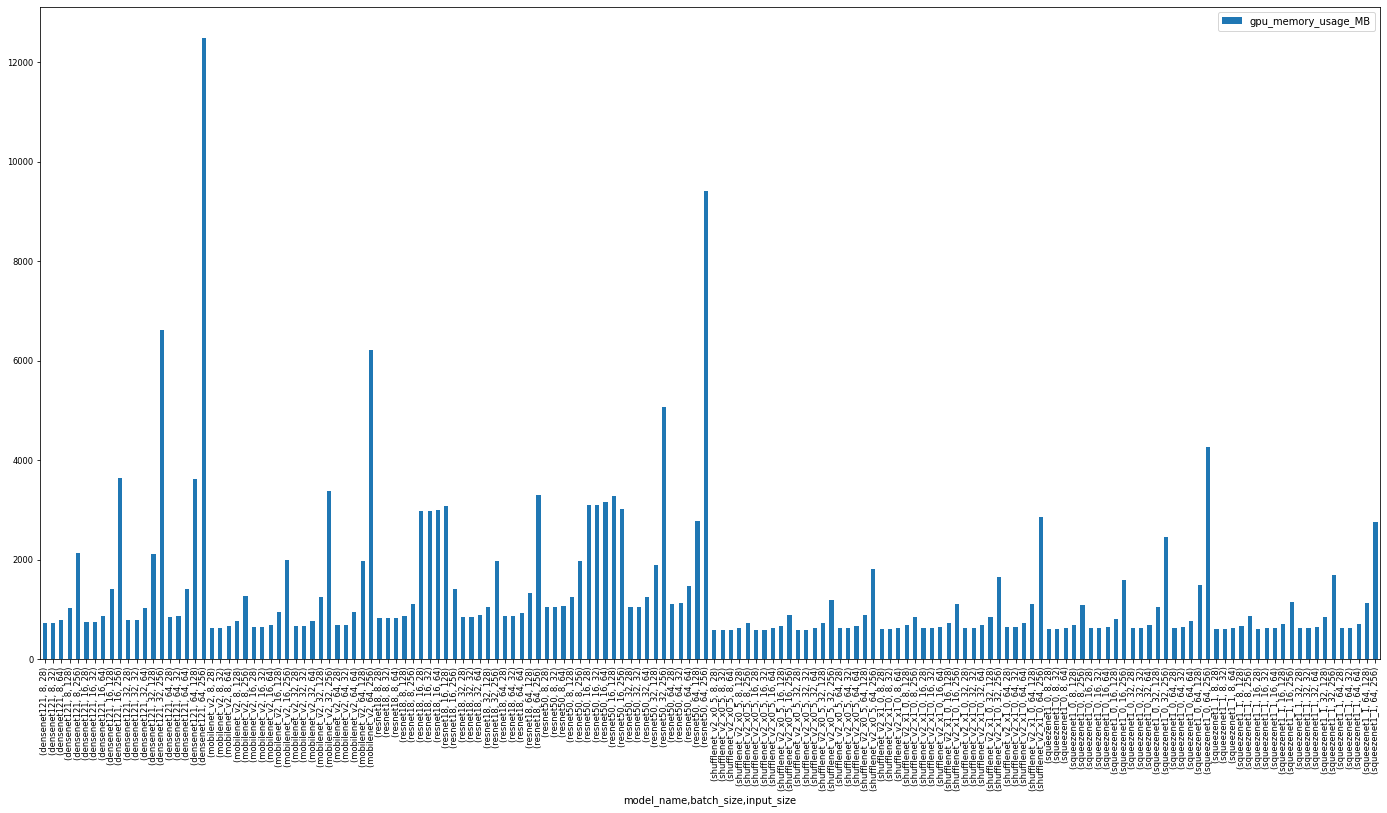

In [15]:
table_mnist.plot(kind='bar', y='gpu_memory_usage_MB', figsize=(24, 12), fontsize='small', title='rmnist');

#### 整体CPU表

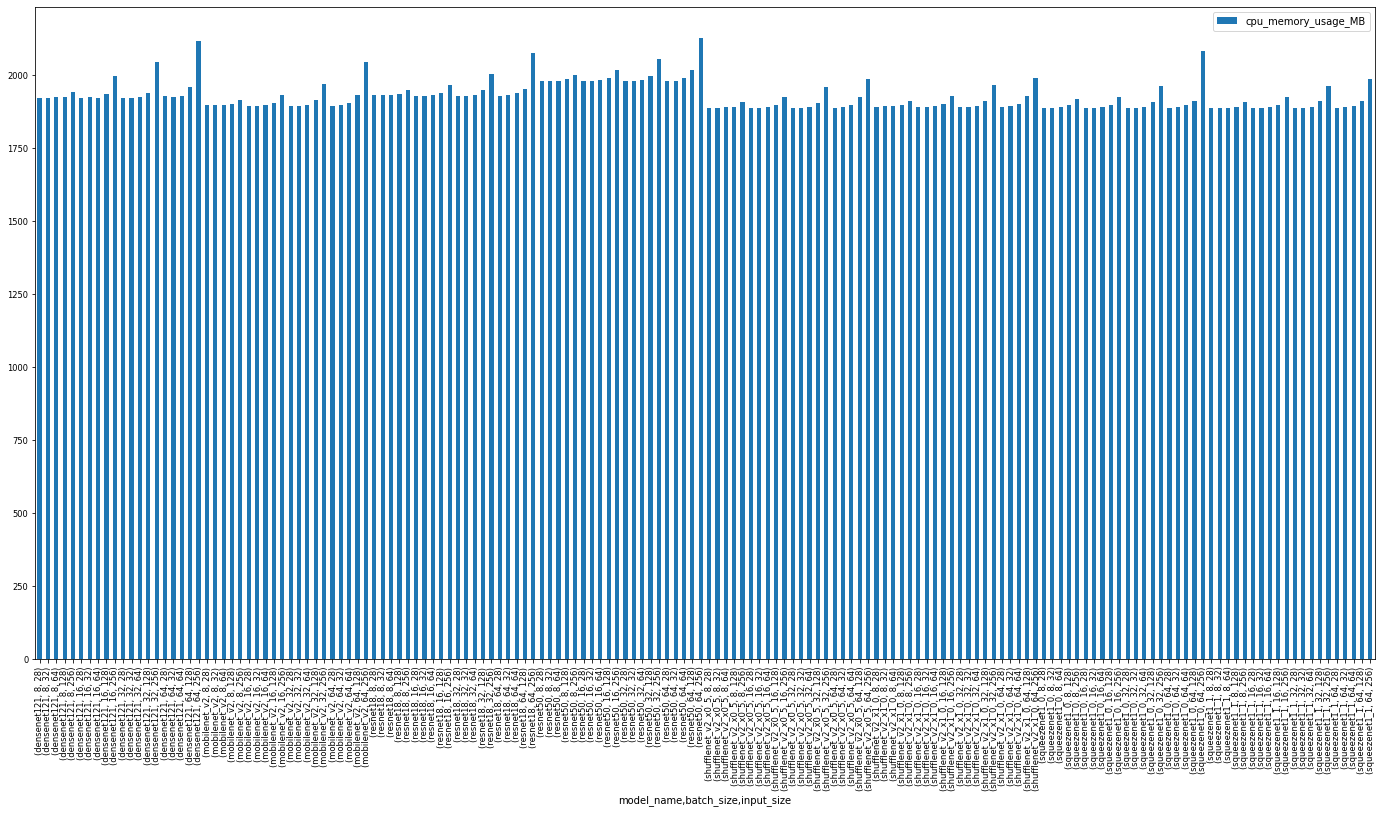

In [16]:
table_mnist.plot(kind='bar', y='cpu_memory_usage_MB', figsize=(24, 12), fontsize='small', title='rmnist');

#### 整体时间消耗表

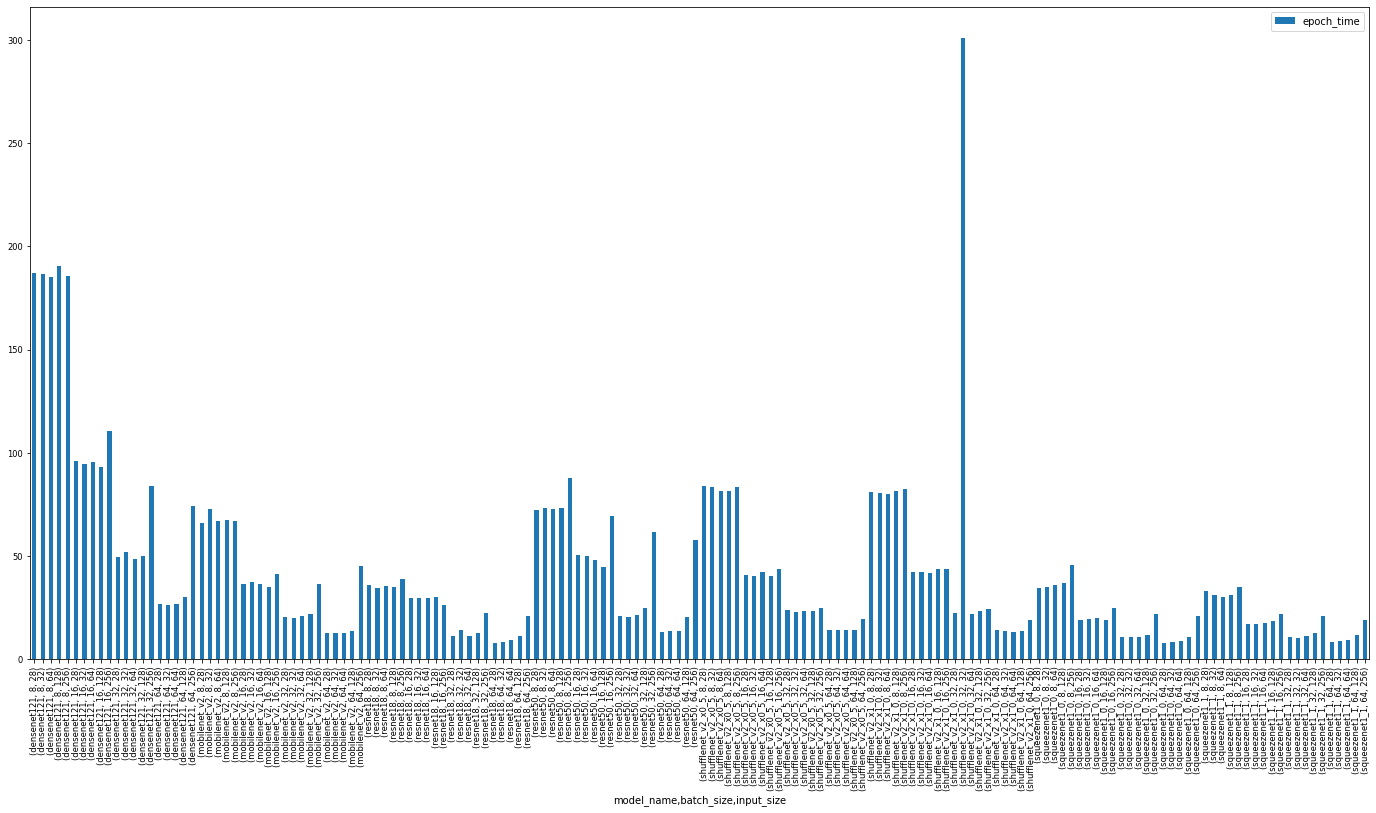

In [17]:
table_mnist.plot(kind='bar', y='epoch_time', figsize=(24, 12), fontsize='small', title='rmnist');

#### 模型GPU表

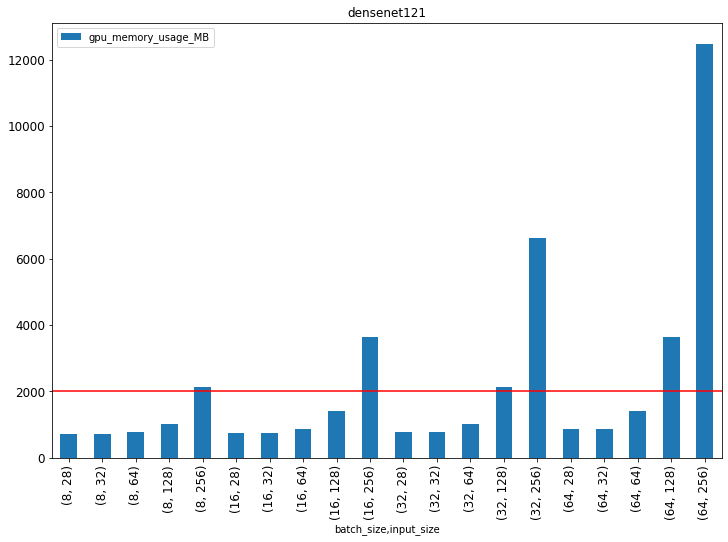

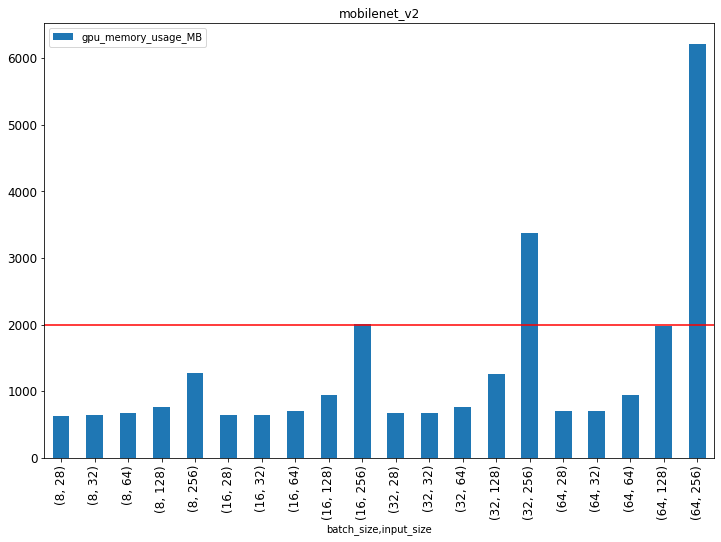

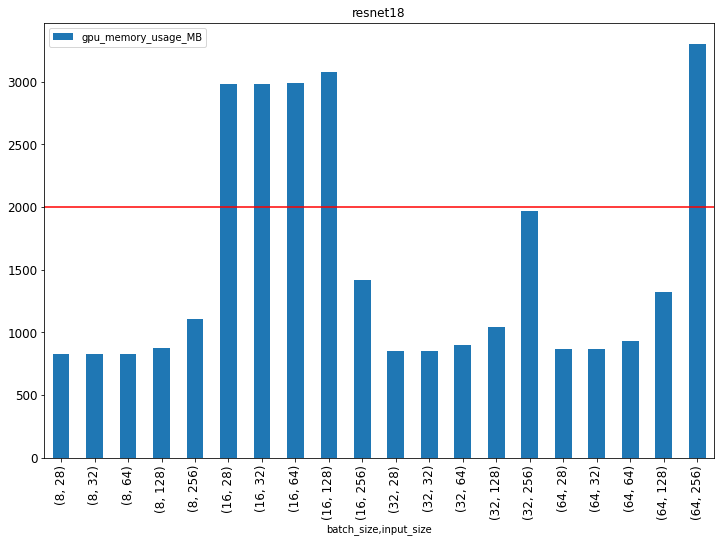

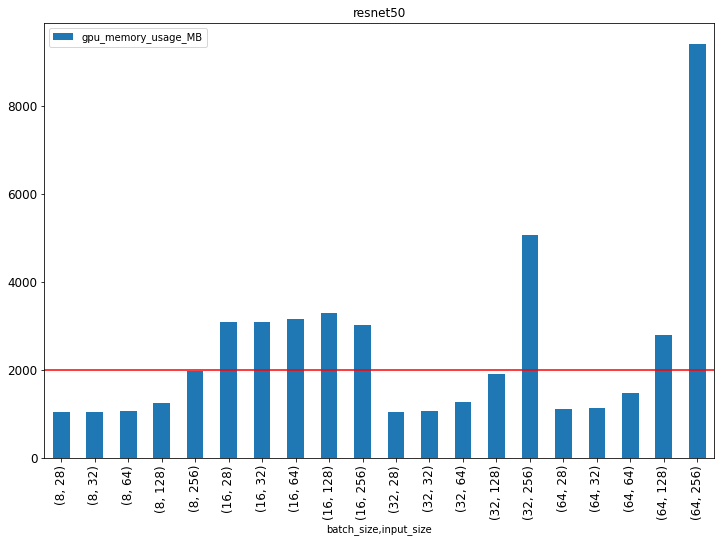

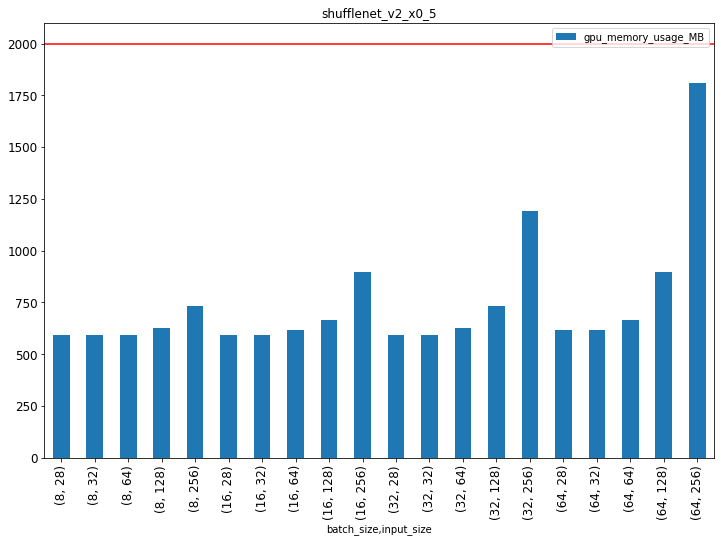

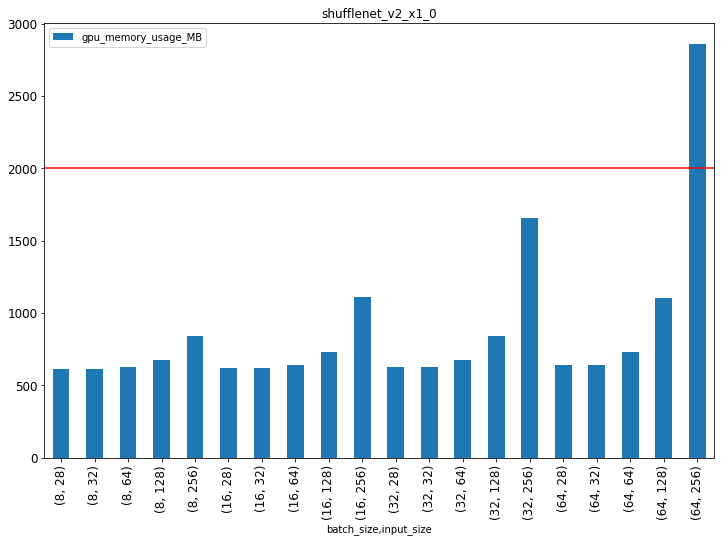

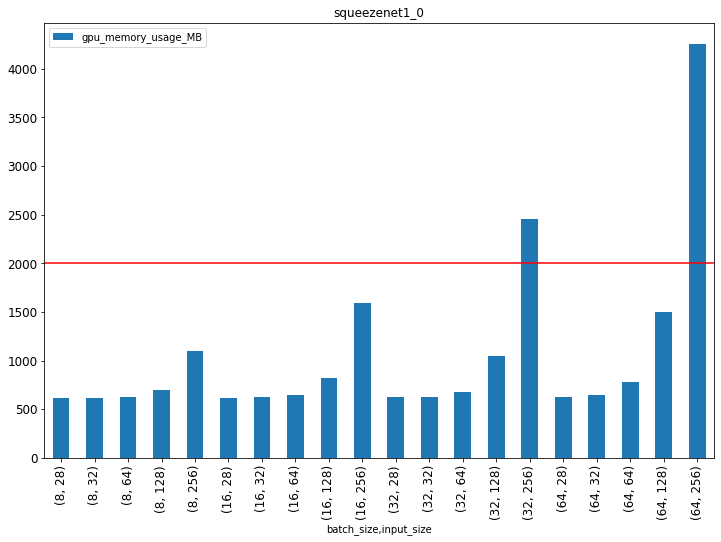

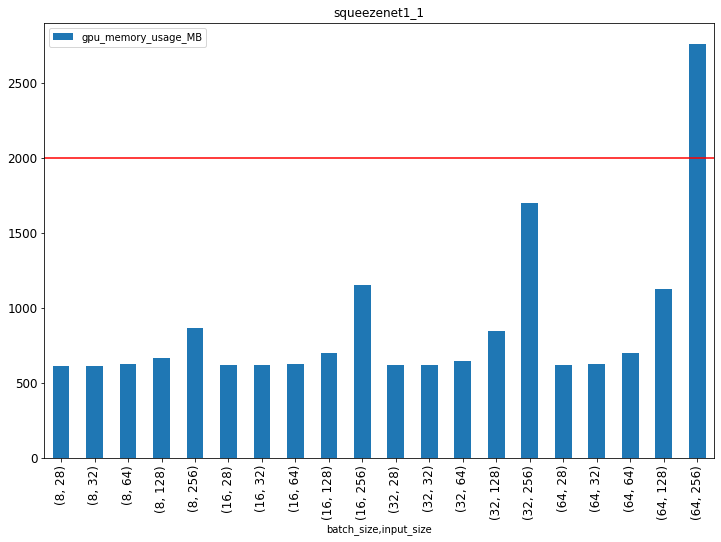

In [18]:
models_grouped = df_mnist.groupby(by='model_name')
for model_name in models_grouped.groups:
    model_df = models_grouped.get_group(model_name)
    table = pd.pivot_table(model_df, index=['batch_size', 'input_size']) 
    table.plot(kind='bar', title=f'{model_name}', y='gpu_memory_usage_MB', figsize=(12, 8), fontsize=12) 
    xmin, xmax = plt.xlim()
    plt.hlines(y=2000, xmin=xmin, xmax=xmax, colors='red')

#### 模型CPU表

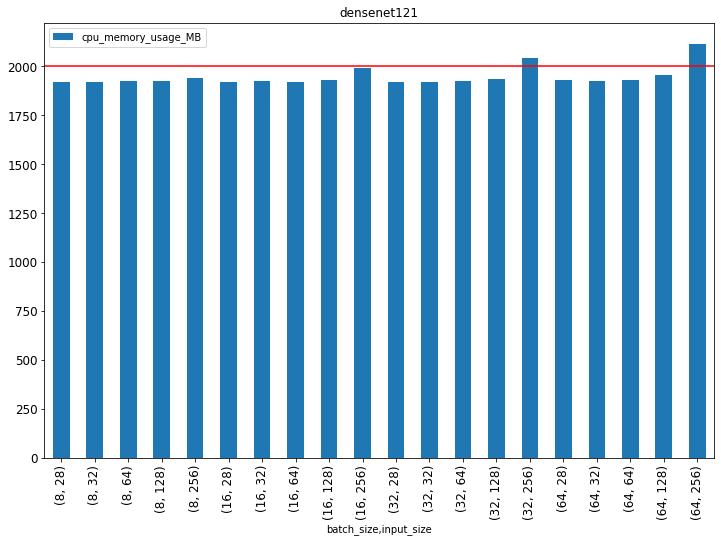

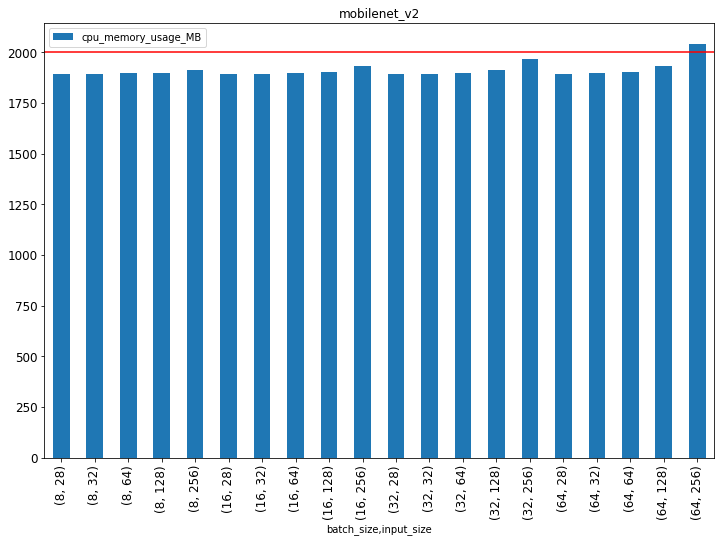

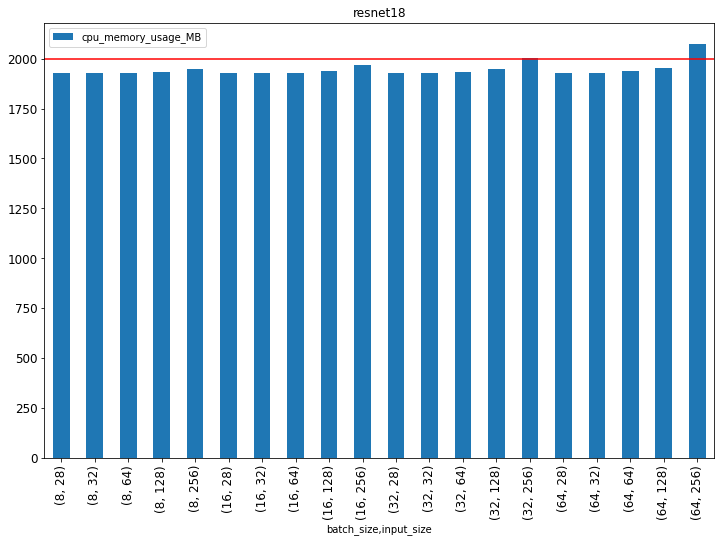

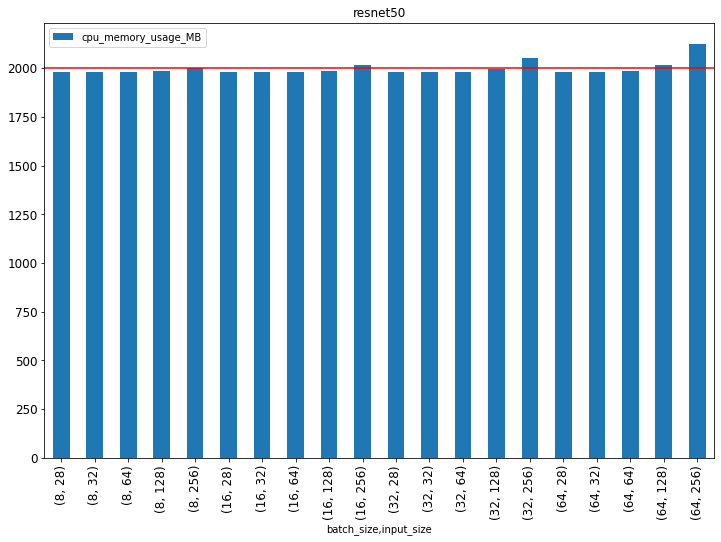

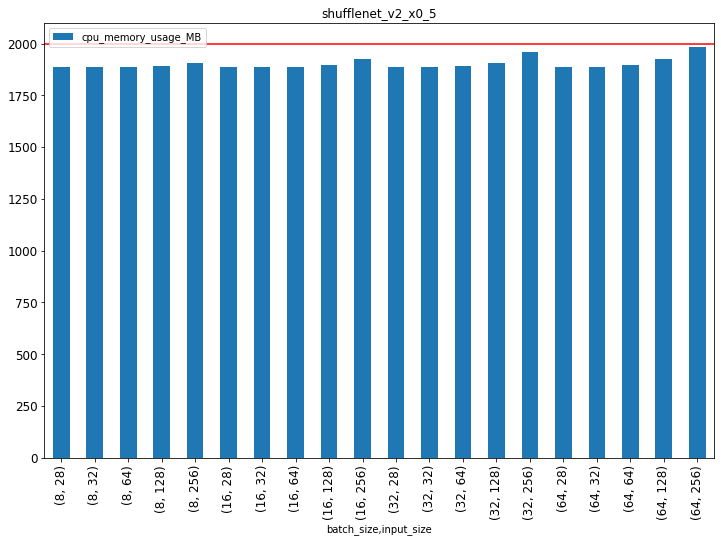

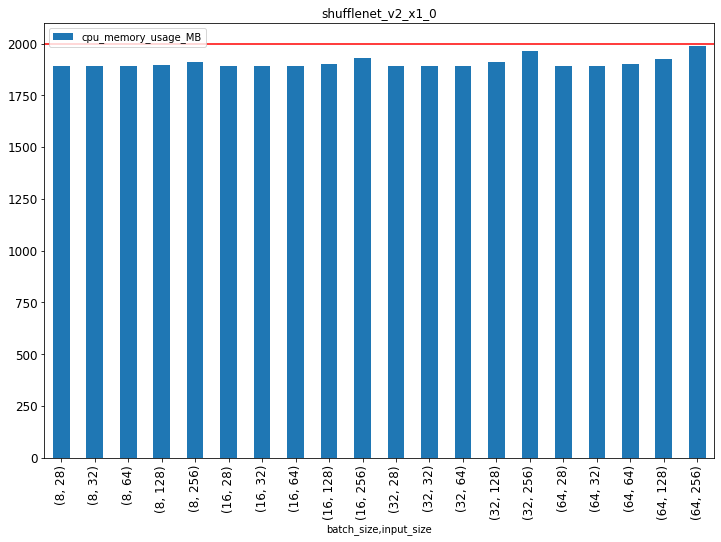

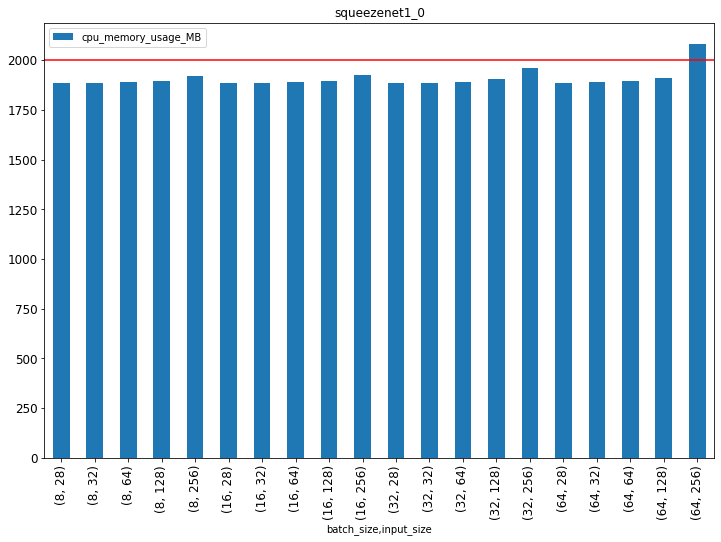

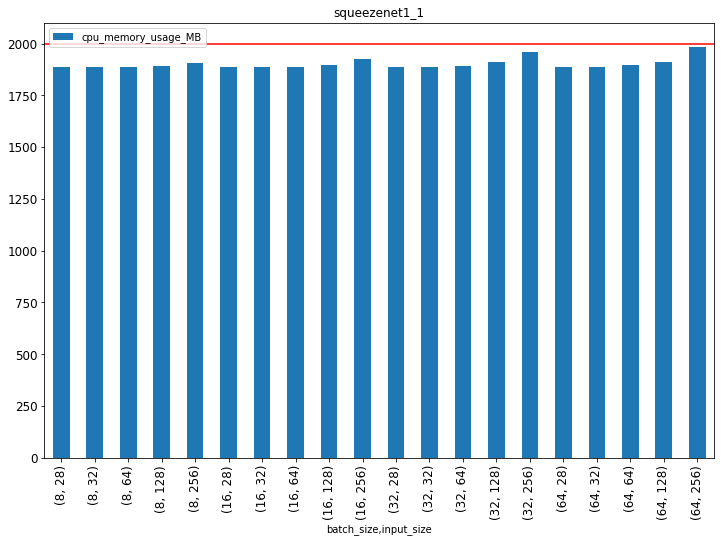

In [19]:
models_grouped = df_mnist.groupby(by='model_name')
for model_name in models_grouped.groups:
    model_df = models_grouped.get_group(model_name)
    table = pd.pivot_table(model_df, index=['batch_size', 'input_size']) 
    table.plot(kind='bar', title=f'{model_name}', y='cpu_memory_usage_MB', figsize=(12, 8), fontsize=12) 
    xmin, xmax = plt.xlim()
    plt.hlines(y=2000, xmin=xmin, xmax=xmax, colors='red')

#### 模型时间消耗表

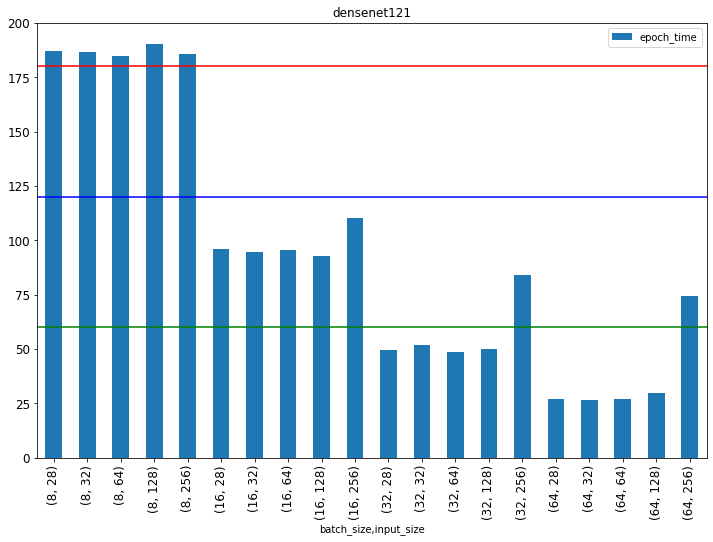

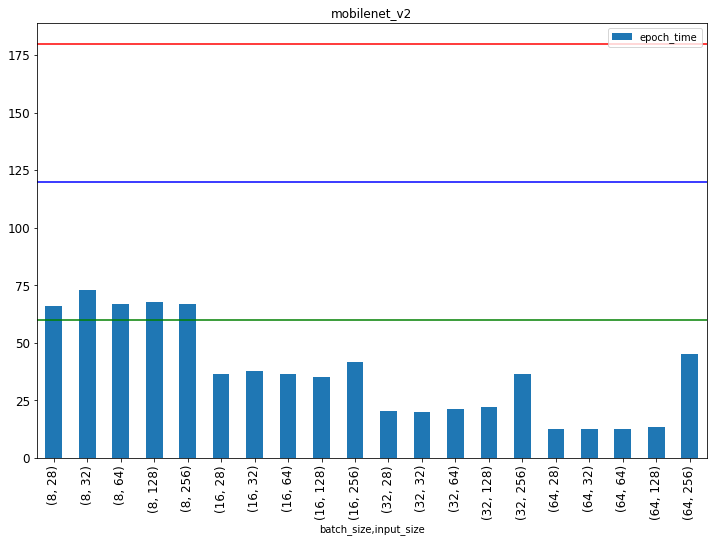

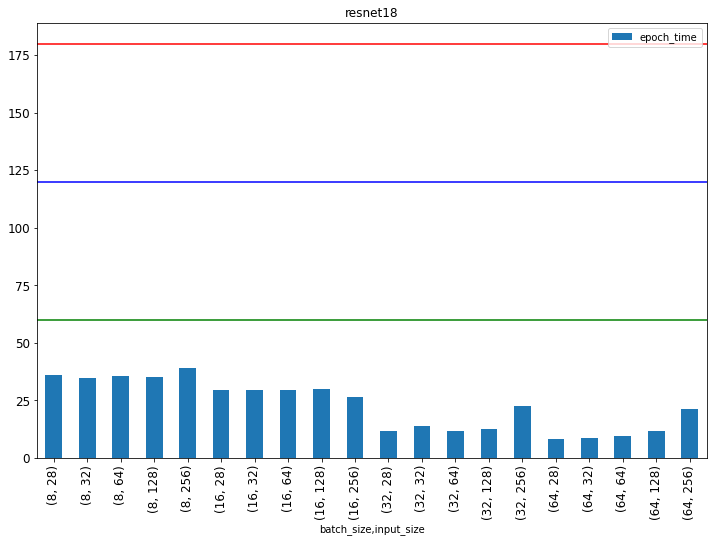

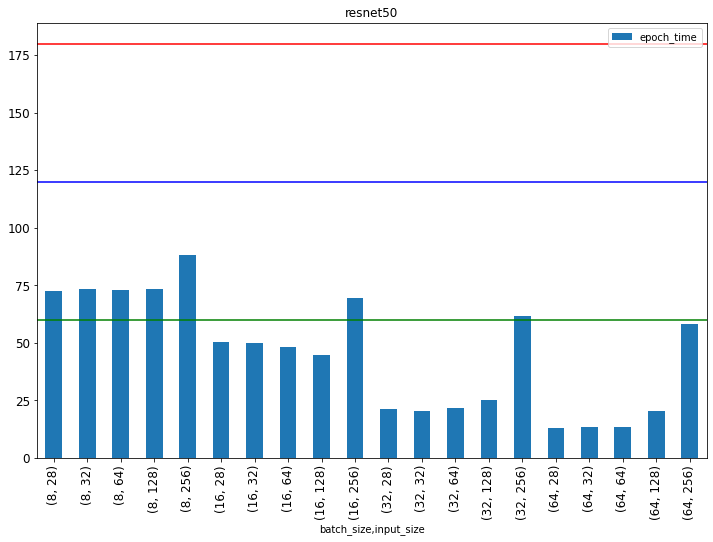

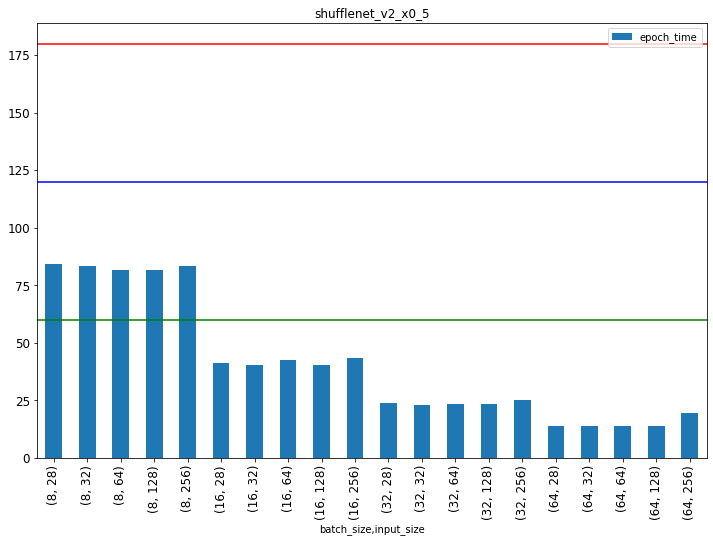

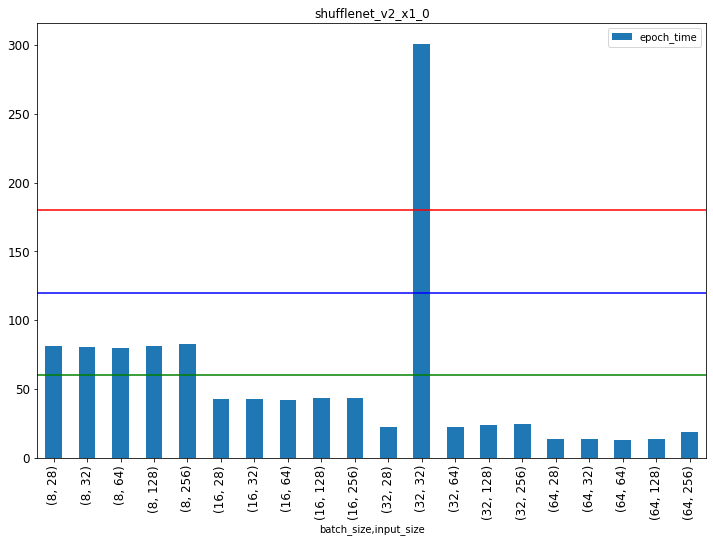

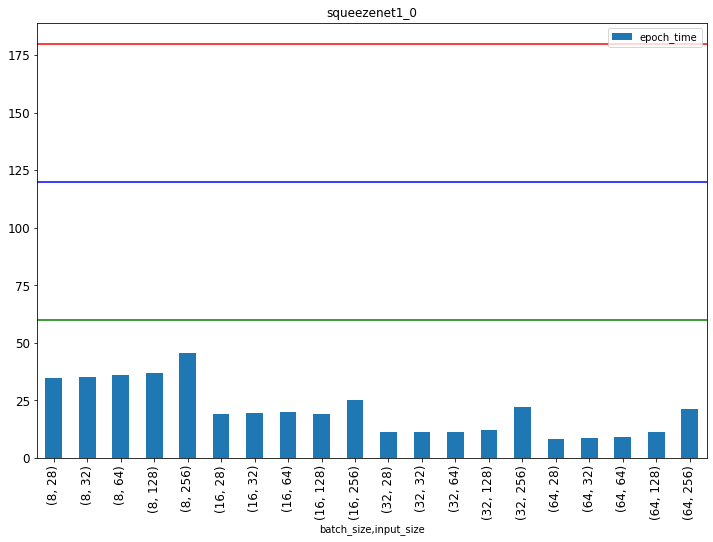

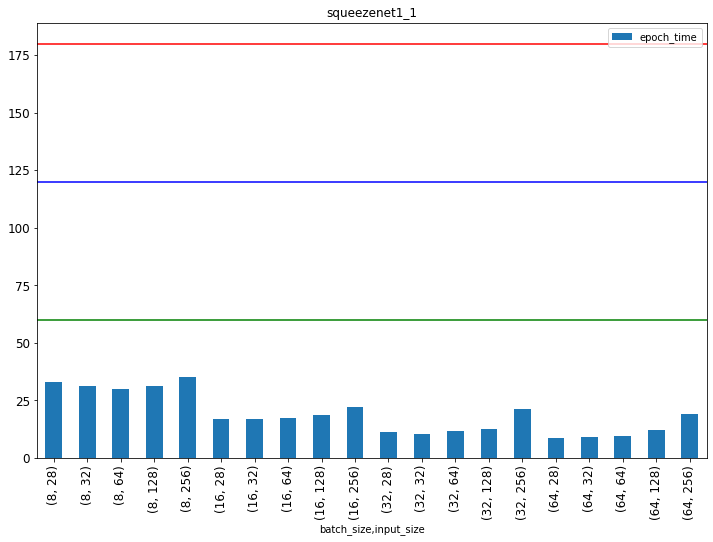

In [20]:
models_grouped = df_mnist.groupby(by='model_name')
for model_name in models_grouped.groups:
    model_df = models_grouped.get_group(model_name)
    table = pd.pivot_table(model_df, index=['batch_size', 'input_size']) 
    table.plot(kind='bar', title=f'{model_name}', y='epoch_time', figsize=(12, 8), fontsize=12) 
    xmin, xmax = plt.xlim()
    plt.hlines(y=60,  xmin=xmin, xmax=xmax, colors='green')
    plt.hlines(y=120, xmin=xmin, xmax=xmax, colors='blue')
    plt.hlines(y=180, xmin=xmin, xmax=xmax, colors='red')

## 分析chestxray

### 读取信息

In [21]:
with open(os.path.join(k12ai_get_top_dir(), 'assets', 'rchestxray_stats.json'), 'r') as f:
    items = json.load(f)
len(items), len(backbones) * len(batch_sizes) * len(input_sizes)

(160, 160)

### 提取信息

In [22]:
# k12ai_print(items[0])

In [23]:
stats = []
for el in items:
    data = el['data']['expand']
    stats.append({
        'dataset_name': data['environ']['dataset_name'],
        'model_name': data['environ']['model_name'],
        'batch_size': int(data['environ']['batch_size']),
        'input_size': eval(data['environ']['input_size'])[0],
        'epoch_time': data['uptime'] / float(data['environ']['num_epochs']),
        'cpu_memory_usage_MB': data['resource']['containers'][0]['cpu_memory_usage_MB'],
        'gpu_memory_usage_MB': data['resource']['containers'][0]['gpu_memory_usage_MB']
    })
stats[0], len(stats) 

({'dataset_name': 'rchestxray',
  'model_name': 'resnet18',
  'batch_size': 8,
  'input_size': 28,
  'epoch_time': 6.0,
  'cpu_memory_usage_MB': 1963.266,
  'gpu_memory_usage_MB': 1063},
 160)

### 图表显示

In [24]:
df_xray = pd.DataFrame(stats)

#### 低于2G组合

In [25]:
df_gpu2G = df_xray[df_xray['gpu_memory_usage_MB'] < 2000]
pd.pivot_table(df_gpu2G, index=['model_name', 'batch_size', 'input_size'])

cpu_memory_usage_MB  epoch_time  \
model_name         batch_size input_size                                    
densenet121        8          28                     1955.387        12.5   
                              32                     1955.246        12.5   
                              64                     1973.637        12.5   
                              128                    1975.852        12.0   
                   16         28                     1954.426         8.0   
                              32                     1954.371         8.0   
                              64                     1957.023         8.0   
                              128                    1963.676         8.0   
                   32         28                     1954.191         5.5   
                              32                     1956.336         6.0   
                              64                     1957.996         6.0   
                   64         28                     1956.371         4.5   
                              32                     1957.809         5.0   
                              64                     1962.766         4.5   
mobilenet_v2       8          28                     1929.176         7.5   
                              32                     1929.500         7.5   
                              64                     1929.414         7.5   
                              128                    1934.523         7.5   
                              224                    1943.750         7.5   
                   16         28                     1928.574         5.5   
                              32                     1928.945         5.5   
                              64                     1930.574         5.5   
                              128                    1938.562         5.5   
                              224                    1957.367         5.5   
                   32         28                     1928.695         4.5   
                              32                     1928.797         4.5   
                              64                     1930.781         4.5   
                              128                    1947.684         4.5   
                   64         28                     1928.344         4.0   
                              32                     1928.402         4.0   
                              64                     1934.879         4.0   
resnet18           8          28                     1963.266         6.0   
                              32                     1963.668         6.0   
                              64                     1963.129         6.0   
                              128                    1967.742         6.5   
                              224                    1977.336         6.5   
                   16         224                    1990.801         5.0   
                   32         28                     1961.863         4.5   
                              32                     1962.590         4.5   
                              64                     1964.559         4.5   
                              128                    1975.277         4.5   
                              224                    1981.371         4.5   
                   64         28                     1961.945         4.5   
                              32                     1962.367         4.5   
                              64                     1968.426         4.5   
                              128                    1986.965         4.5   
resnet50           8          28                     2013.332         8.5   
                              32                     2013.012         8.0   
                              64                     2013.113         8.5   
                              128                    2017.793         8.5   
                   32         28      

#### 整体分组表

In [26]:
table_xray = pd.pivot_table(df_xray, index=['model_name', 'batch_size', 'input_size'])
table_xray

cpu_memory_usage_MB  epoch_time  \
model_name         batch_size input_size                                    
densenet121        8          28                     1955.387        12.5   
                              32                     1955.246        12.5   
                              64                     1973.637        12.5   
                              128                    1975.852        12.0   
                              224                    1973.863        12.5   
                   16         28                     1954.426         8.0   
                              32                     1954.371         8.0   
                              64                     1957.023         8.0   
                              128                    1963.676         8.0   
                              224                    1983.758         8.5   
                   32         28                     1954.191         5.5   
                              32                     1956.336         6.0   
                              64                     1957.996         6.0   
                              128                    1972.566         5.5   
                              224                    1976.172         6.5   
                   64         28                     1956.371         4.5   
                              32                     1957.809         5.0   
                              64                     1962.766         4.5   
                              128                    1991.801         5.0   
                              224                    2031.984         6.0   
mobilenet_v2       8          28                     1929.176         7.5   
                              32                     1929.500         7.5   
                              64                     1929.414         7.5   
                              128                    1934.523         7.5   
                              224                    1943.750         7.5   
                   16         28                     1928.574         5.5   
                              32                     1928.945         5.5   
                              64                     1930.574         5.5   
                              128                    1938.562         5.5   
                              224                    1957.367         5.5   
                   32         28                     1928.695         4.5   
                              32                     1928.797         4.5   
                              64                     1930.781         4.5   
                              128                    1947.684         4.5   
                              224                    1951.816         5.0   
                   64         28                     1928.344         4.0   
                              32                     1928.402         4.0   
                              64                     1934.879         4.0   
                              128                    1953.203         4.0   
                              224                    2006.004         5.0   
resnet18           8          28                     1963.266         6.0   
                              32                     1963.668         6.0   
                              64                     1963.129         6.0   
                              128                    1967.742         6.5   
                              224                    1977.336         6.5   
                   16         28                     1962.824         5.0   
                              32                     1962.551         5.5   
                              64                     1964.789         5.5   
                              128                    1971.910         5.0   
                              224                    1990.801         5.0   
                   32         28      

#### 整体GPU表

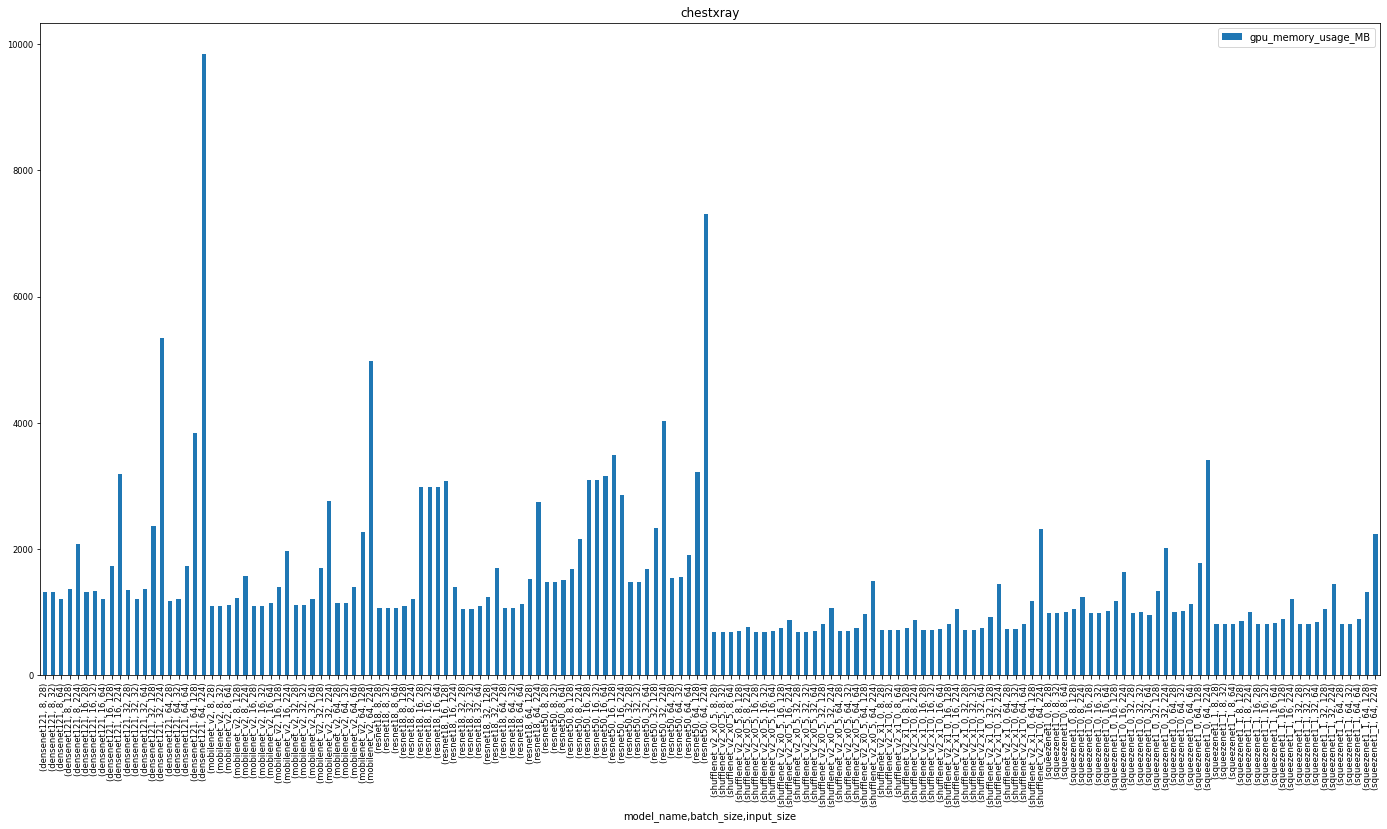

In [27]:
table_xray.plot(kind='bar', y='gpu_memory_usage_MB', figsize=(24, 12), fontsize='small', title='chestxray');

#### 整体CPU表

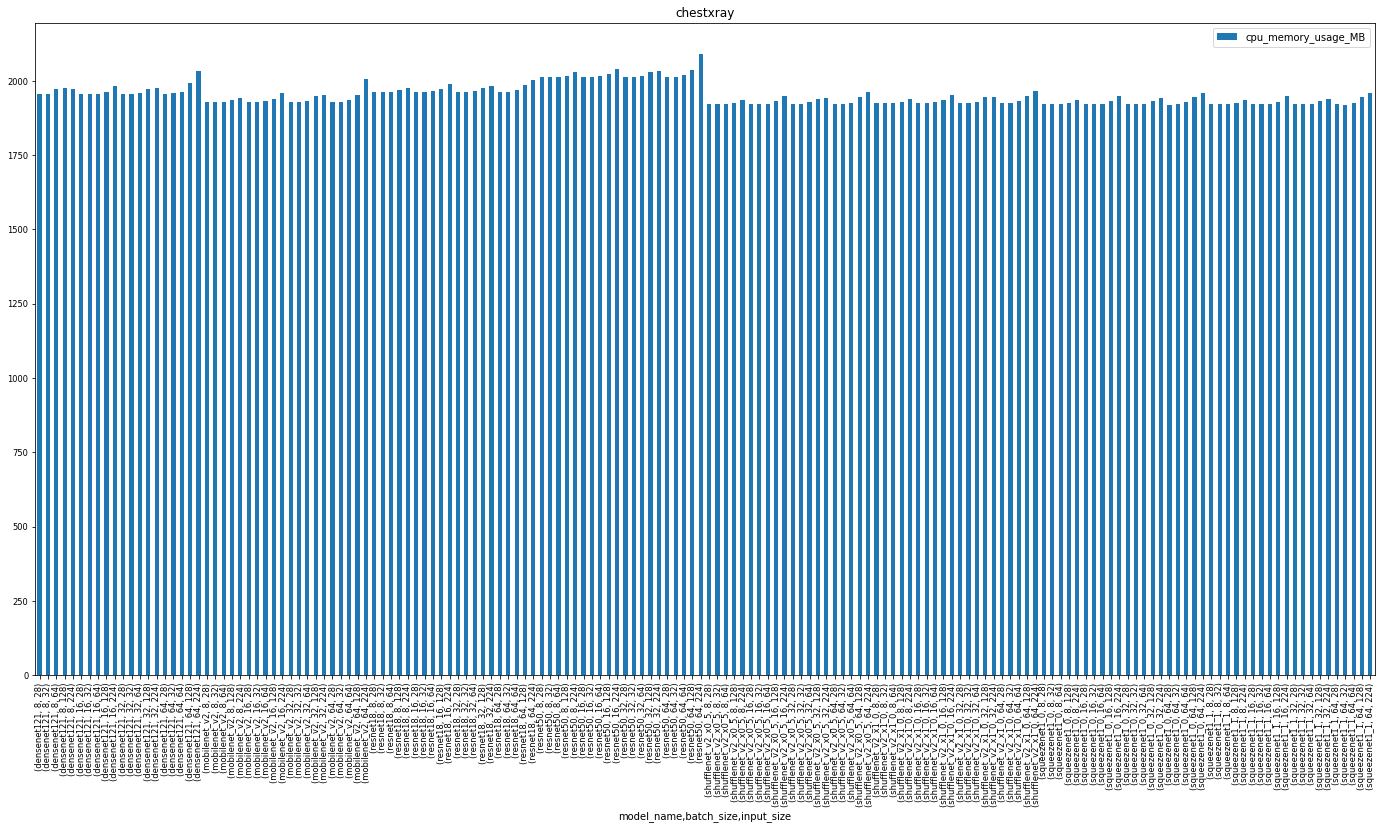

In [28]:
table_xray.plot(kind='bar', y='cpu_memory_usage_MB', figsize=(24, 12), fontsize='small', title='chestxray');

#### 整体时间消耗表

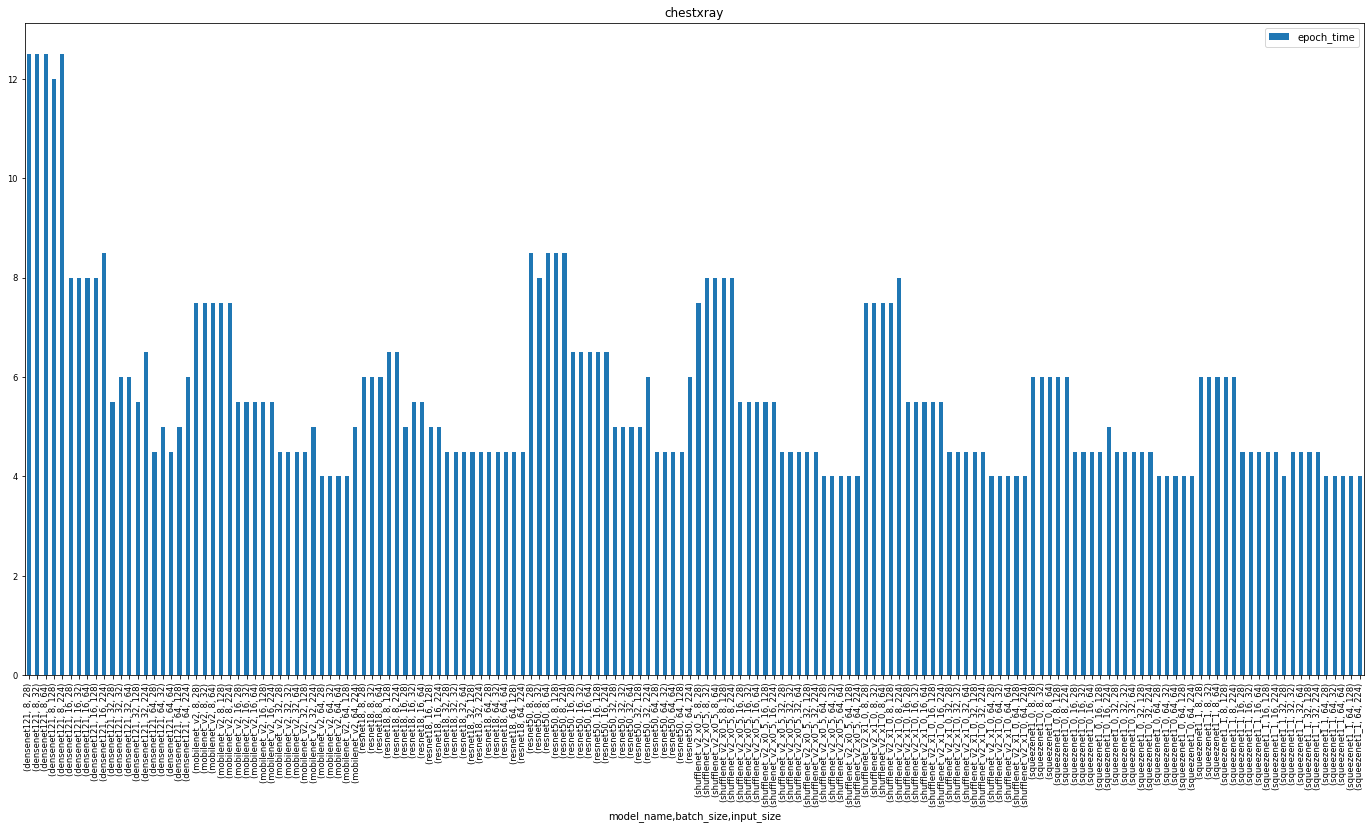

In [29]:
table_xray.plot(kind='bar', y='epoch_time', figsize=(24, 12), fontsize='small', title='chestxray');

#### 模型GPU表

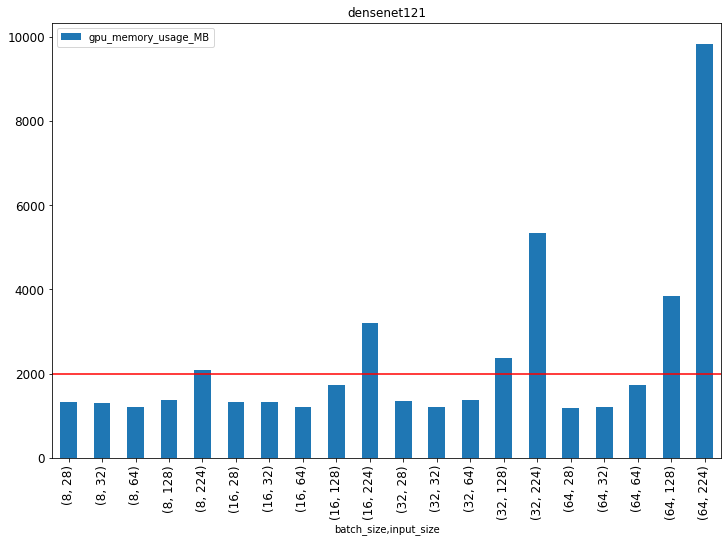

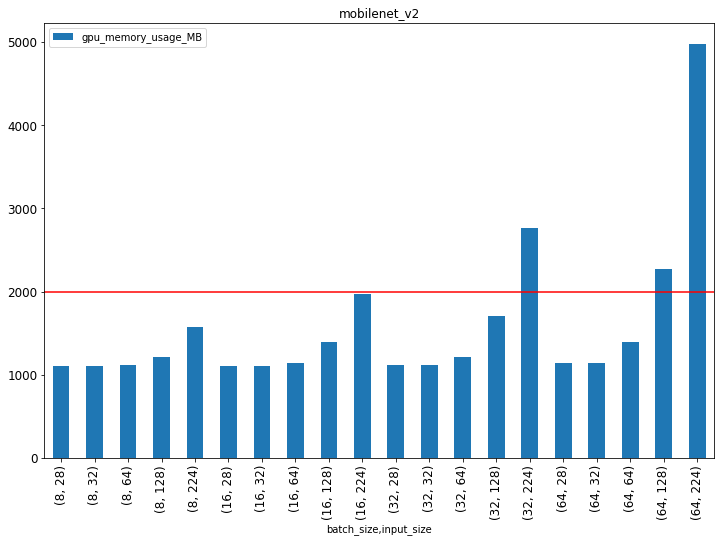

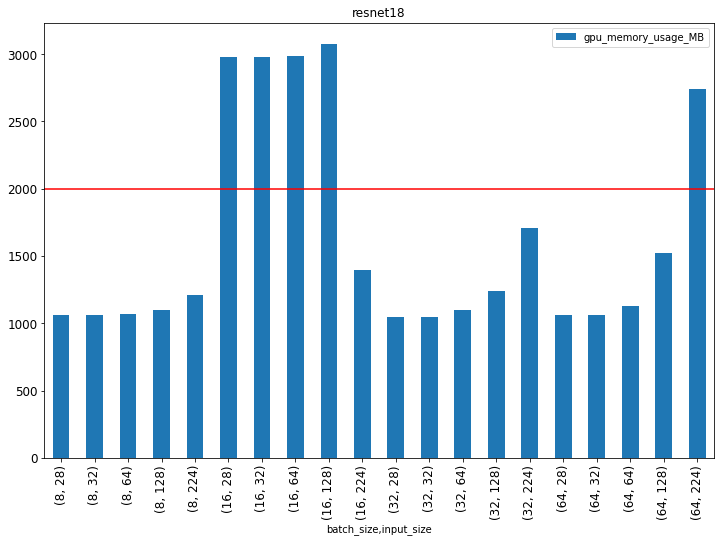

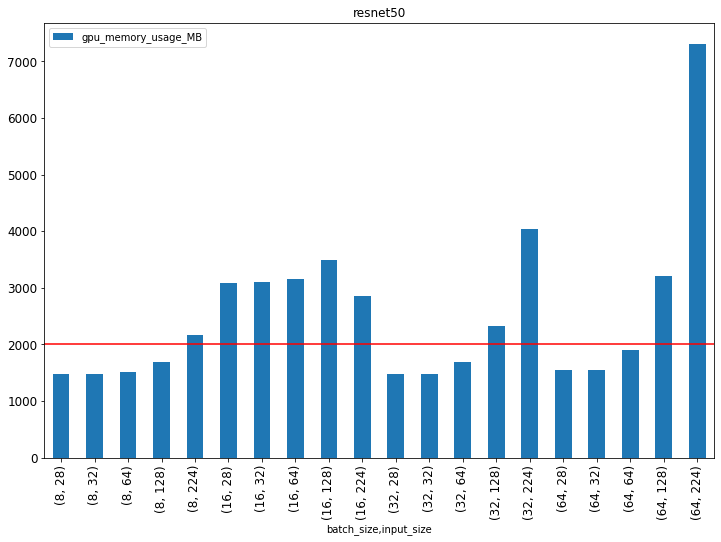

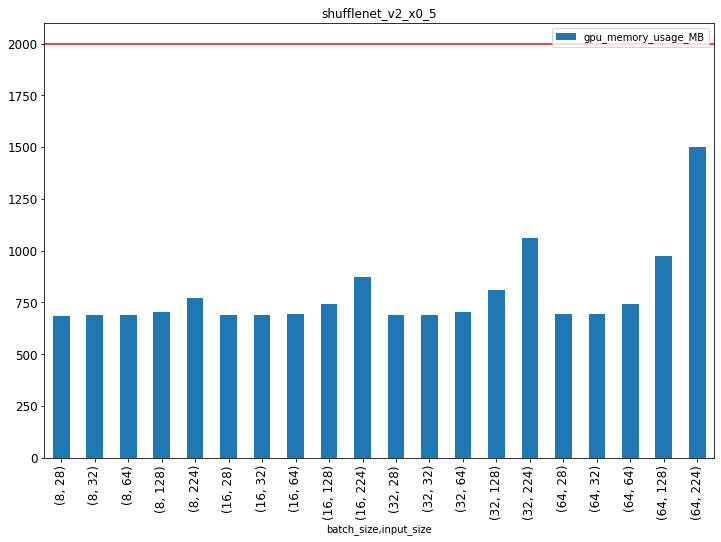

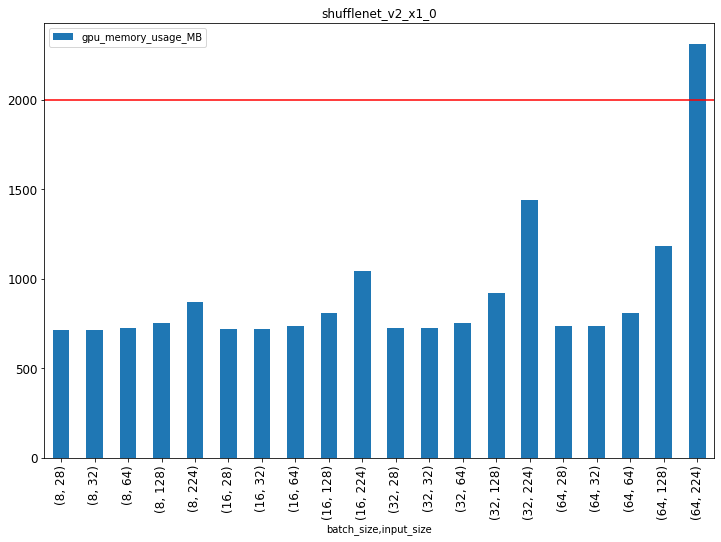

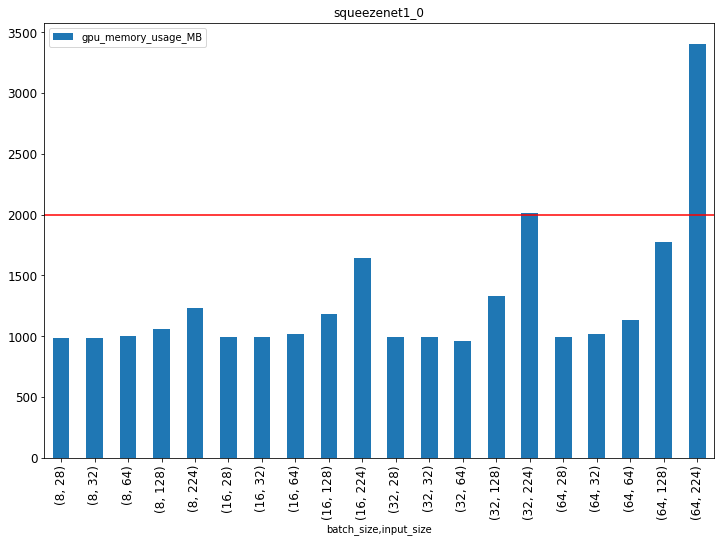

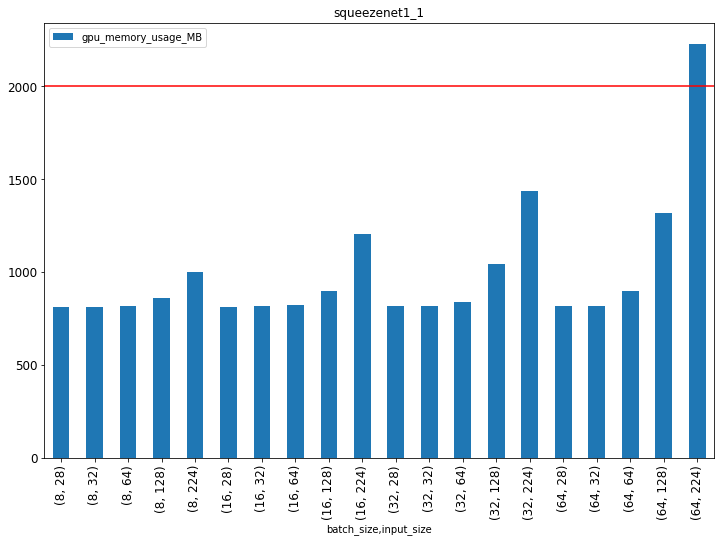

In [30]:
models_grouped = df_xray.groupby(by='model_name')
for model_name in models_grouped.groups:
    model_df = models_grouped.get_group(model_name)
    table = pd.pivot_table(model_df, index=['batch_size', 'input_size']) 
    table.plot(kind='bar', title=f'{model_name}', y='gpu_memory_usage_MB', figsize=(12, 8), fontsize=12) 
    xmin, xmax = plt.xlim()
    plt.hlines(y=2000, xmin=xmin, xmax=xmax, colors='red')

#### 模型CPU表

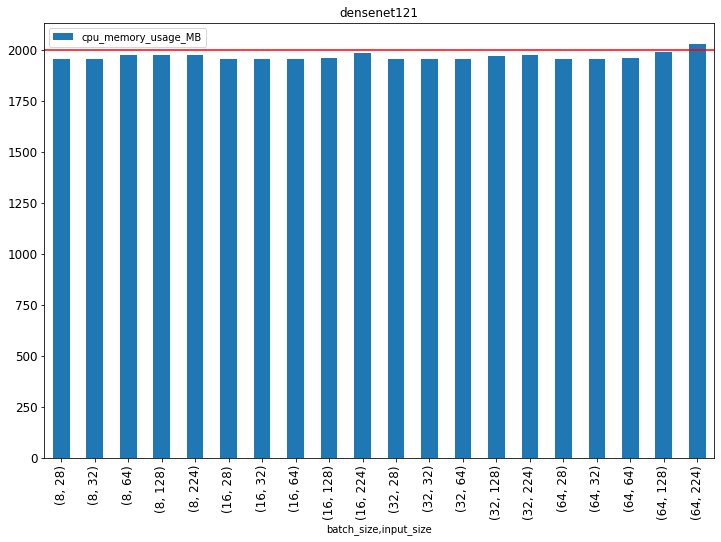

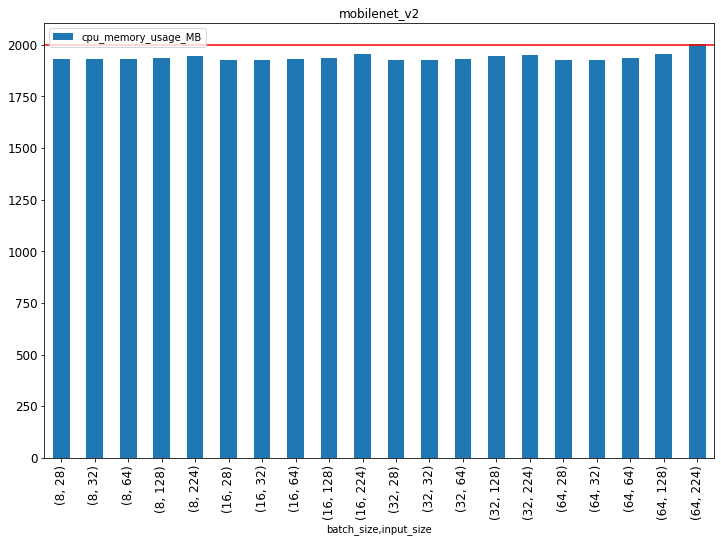

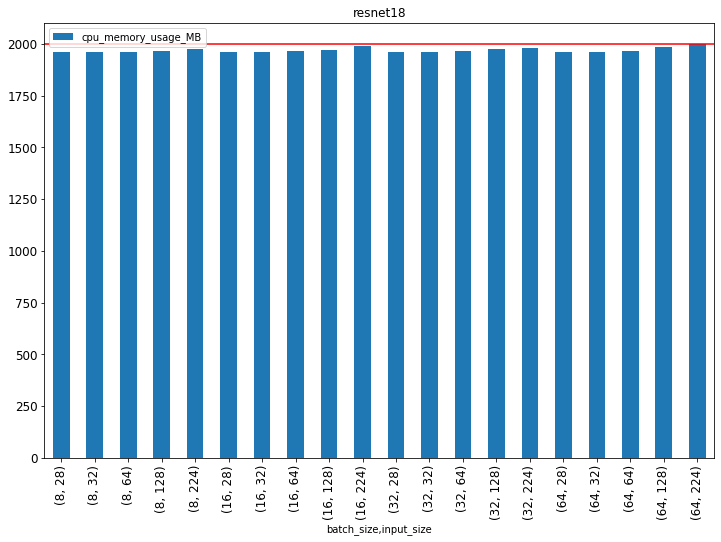

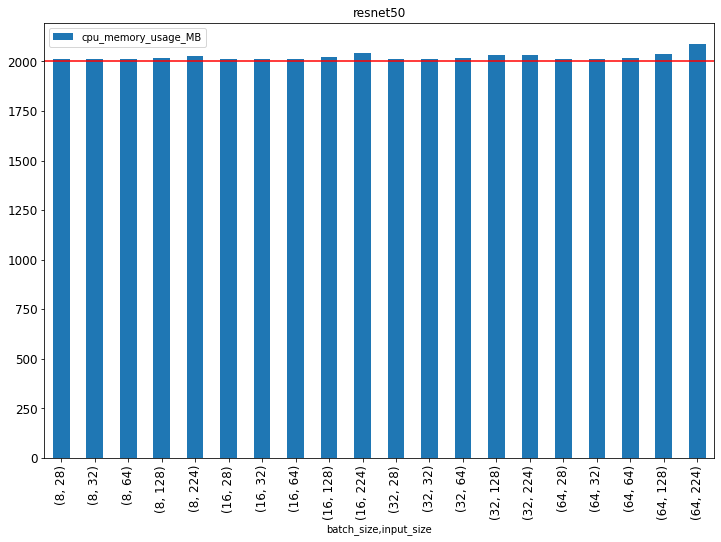

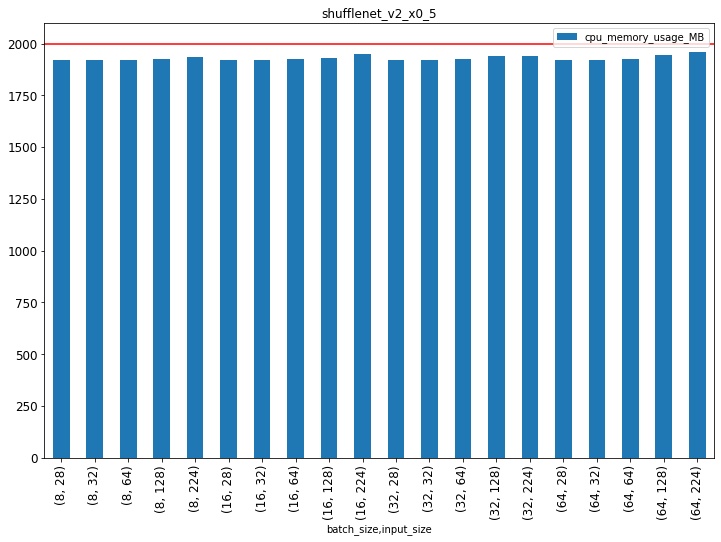

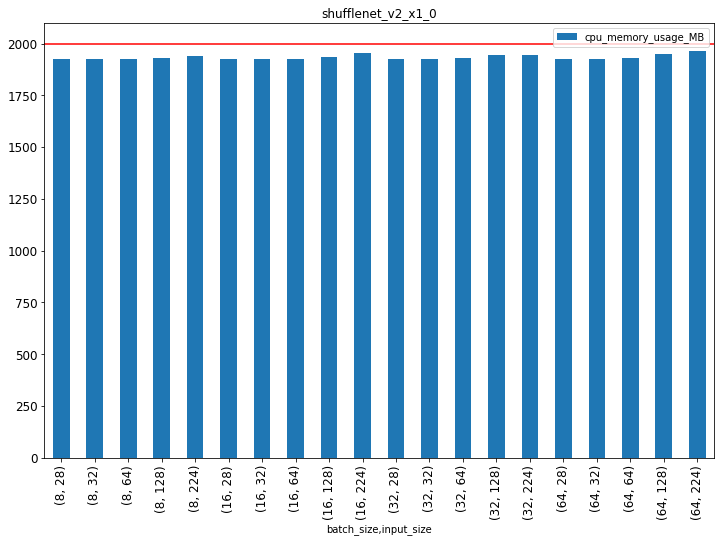

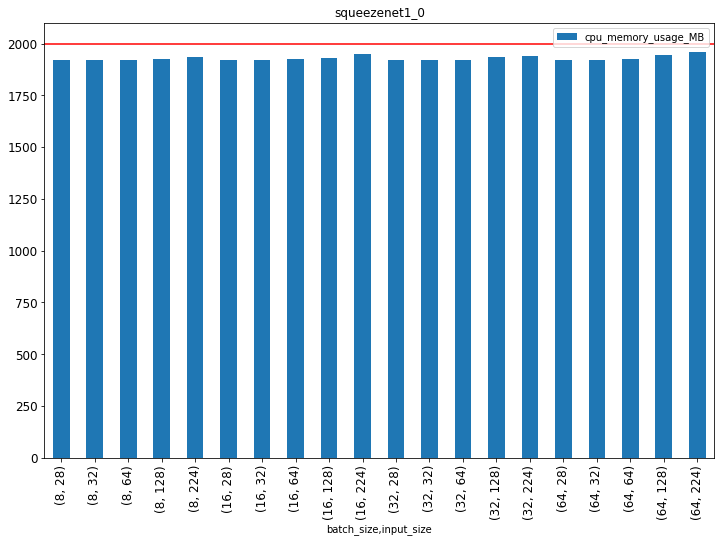

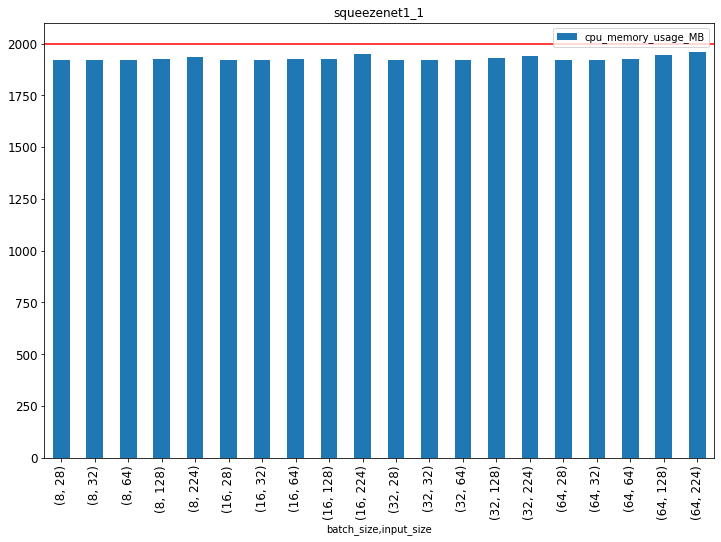

In [31]:
models_grouped = df_xray.groupby(by='model_name')
for model_name in models_grouped.groups:
    model_df = models_grouped.get_group(model_name)
    table = pd.pivot_table(model_df, index=['batch_size', 'input_size']) 
    table.plot(kind='bar', title=f'{model_name}', y='cpu_memory_usage_MB', figsize=(12, 8), fontsize=12) 
    xmin, xmax = plt.xlim()
    plt.hlines(y=2000, xmin=xmin, xmax=xmax, colors='red')

#### 模型时间消耗表

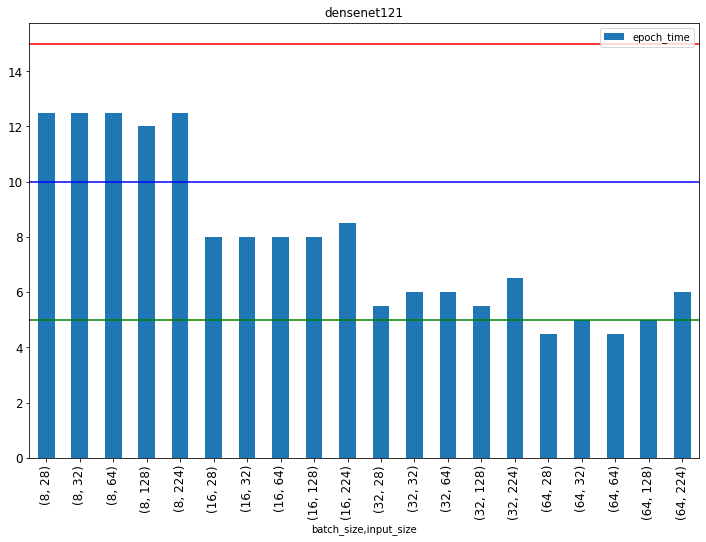

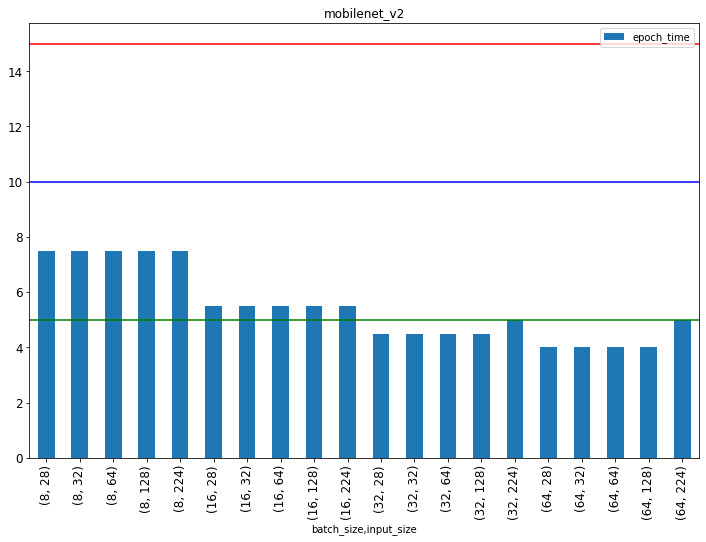

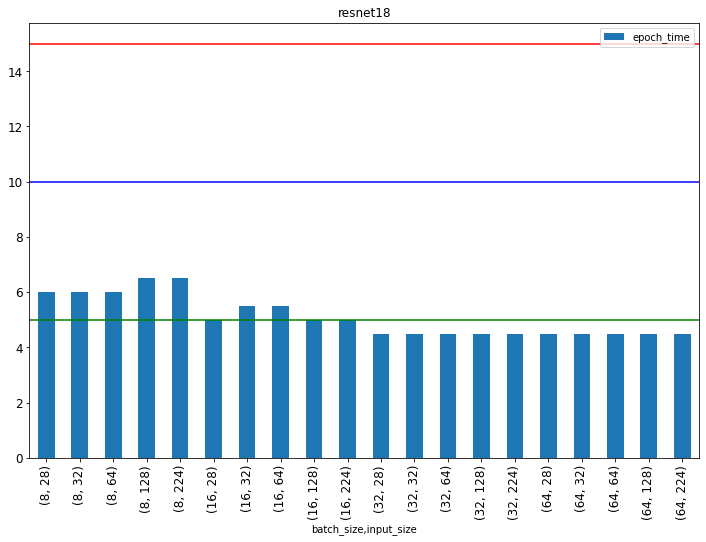

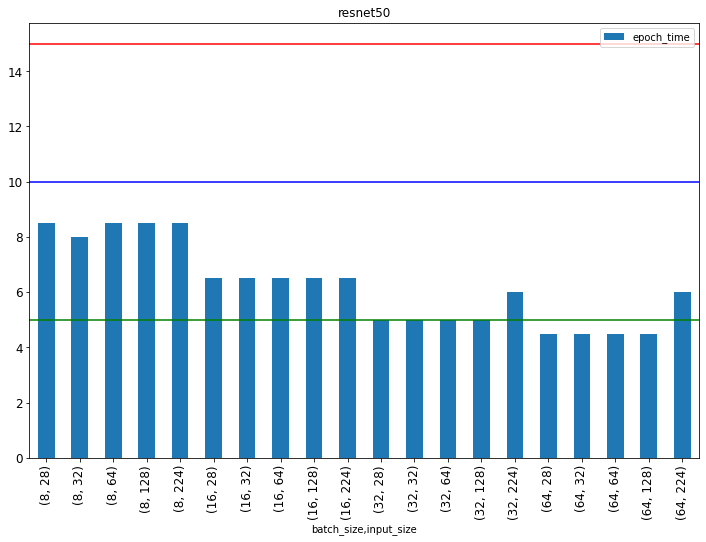

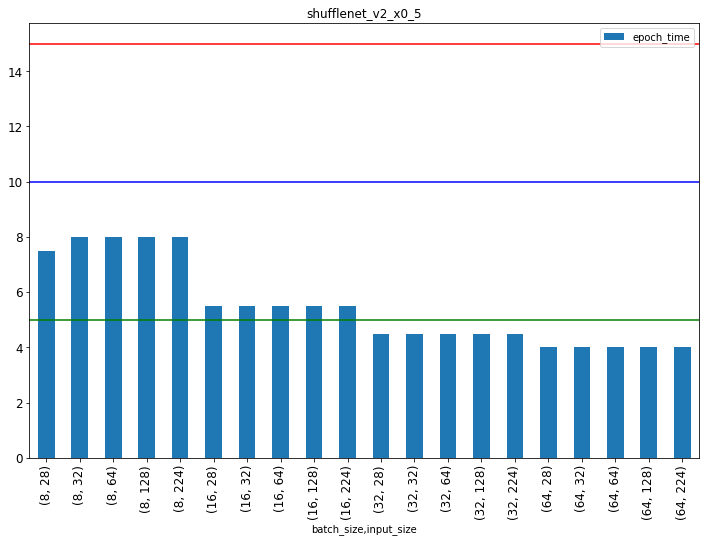

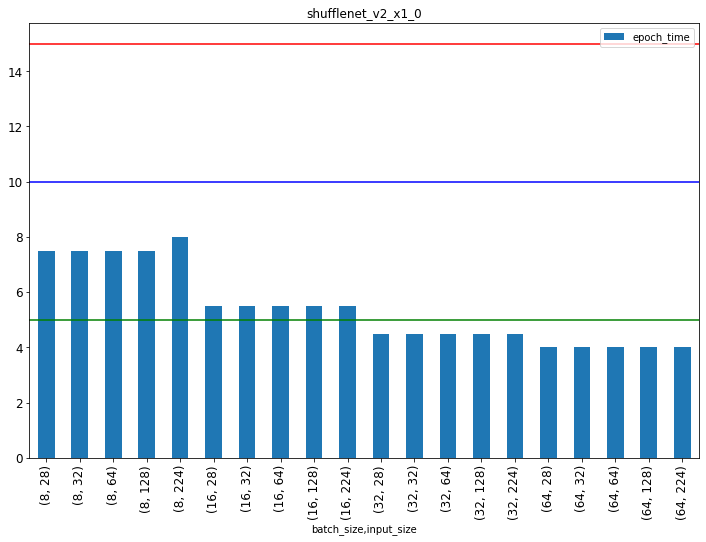

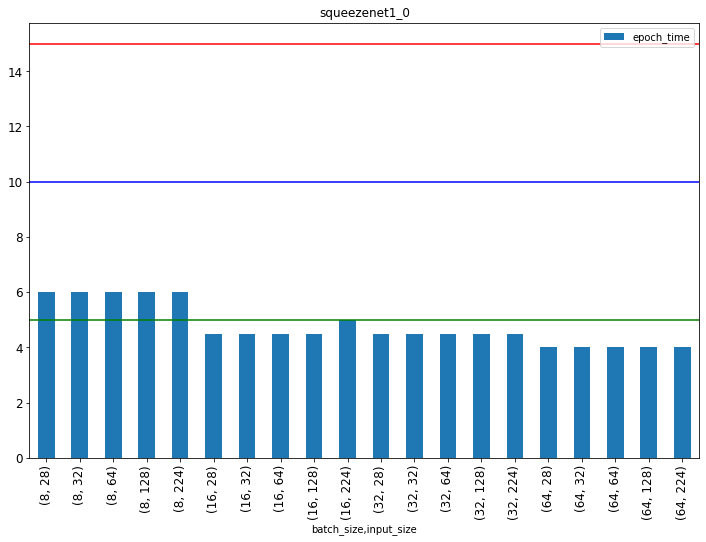

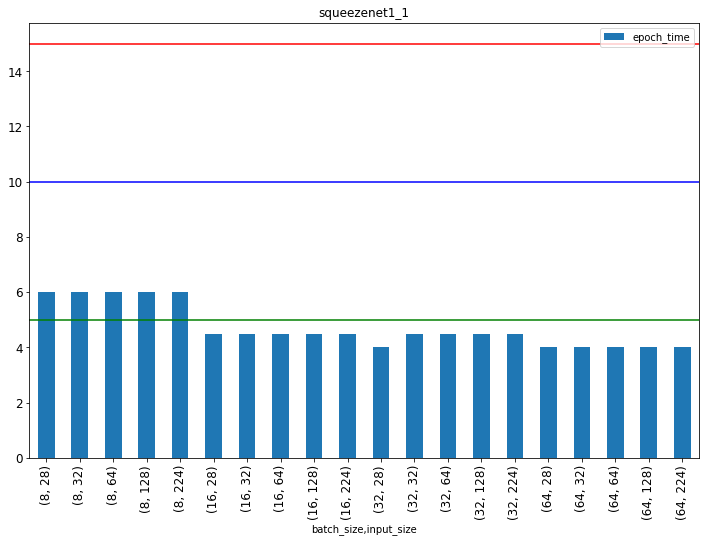

In [32]:
models_grouped = df_xray.groupby(by='model_name')
for model_name in models_grouped.groups:
    model_df = models_grouped.get_group(model_name)
    table = pd.pivot_table(model_df, index=['batch_size', 'input_size']) 
    table.plot(kind='bar', title=f'{model_name}', y='epoch_time', figsize=(12, 8), fontsize=12) 
    xmin, xmax = plt.xlim()
    plt.hlines(y=5, xmin=xmin, xmax=xmax, colors='green')
    plt.hlines(y=10, xmin=xmin, xmax=xmax, colors='blue')
    plt.hlines(y=15, xmin=xmin, xmax=xmax, colors='red')

## 分析flowers

### 读取信息

In [33]:
with open(os.path.join(k12ai_get_top_dir(), 'assets', 'flowers_stats.json'), 'r') as f:
    items = json.load(f)
len(items), len(backbones) * len(batch_sizes) * len(input_sizes)

(160, 160)

### 提取信息

In [34]:
# k12ai_print(items[0])

In [35]:
stats = []
for el in items:
    data = el['data']['expand']
    stats.append({
        'dataset_name': data['environ']['dataset_name'],
        'model_name': data['environ']['model_name'],
        'batch_size': int(data['environ']['batch_size']),
        'input_size': eval(data['environ']['input_size'])[0],
        'epoch_time': data['uptime'] / float(data['environ']['num_epochs']),
        'cpu_memory_usage_MB': data['resource']['containers'][0]['cpu_memory_usage_MB'],
        'gpu_memory_usage_MB': data['resource']['containers'][0]['gpu_memory_usage_MB']
    })
stats[0], len(stats) 

({'dataset_name': 'flowers',
  'model_name': 'resnet18',
  'batch_size': 8,
  'input_size': 28,
  'epoch_time': 9.5,
  'cpu_memory_usage_MB': 1927.191,
  'gpu_memory_usage_MB': 867},
 160)

### 图表显示

In [36]:
df_flowers = pd.DataFrame(stats)

#### 低于2G组合

In [37]:
df_gpu2G = df_flowers[df_flowers['gpu_memory_usage_MB'] < 2000]
pd.pivot_table(df_gpu2G, index=['model_name', 'batch_size', 'input_size'])

cpu_memory_usage_MB  epoch_time  \
model_name         batch_size input_size                                    
densenet121        8          28                     1919.059        40.0   
                              32                     1918.863        39.5   
                              64                     1919.082        39.5   
                              128                    1923.176        39.0   
                              224                    1933.320        41.0   
                   16         28                     1918.930        22.0   
                              32                     1919.078        22.0   
                              64                     1921.367        21.5   
                              128                    1929.000        22.5   
                   32         28                     1919.121        13.5   
                              32                     1918.922        13.5   
                              64                     1922.684        13.0   
                   64         28                     1922.836         9.0   
                              32                     1919.133         9.0   
                              64                     1925.750         9.5   
mobilenet_v2       8          28                     1893.305        17.0   
                              32                     1893.348        17.0   
                              64                     1893.270        16.5   
                              128                    1897.762        16.5   
                              224                    1907.496        18.0   
                   16         28                     1893.578        10.5   
                              32                     1893.621        10.0   
                              64                     1895.188        10.5   
                              128                    1902.180        11.0   
                              224                    1922.355        11.0   
                   32         28                     1893.062         8.5   
                              32                     1892.941         8.5   
                              64                     1895.402         9.0   
                              128                    1905.766         9.5   
                   64         28                     1892.883         8.5   
                              32                     1893.434         8.5   
                              64                     1899.117         8.5   
                              128                    1917.660         9.0   
resnet18           8          28                     1927.191         9.5   
                              32                     1926.355         9.5   
                              64                     1926.395        11.0   
                              128                    1931.199        10.0   
                              224                    1941.617        10.0   
                   16         224                    1946.676         9.0   
                   32         28                     1927.160         8.5   
                              32                     1926.871         8.5   
                              64                     1929.109         9.0   
                              128                    1939.316         9.0   
                              224                    1966.004         9.0   
                   64         28                     1926.996         8.5   
                              32                     1926.770         8.5   
                              64                     1933.465         8.5   
                              128                    1952.000         9.0   
resnet50           8          28                     1977.328        17.0   
                              32                     1976.875        17.5   
                              64      

#### 整体分组表

In [38]:
table_flowers = pd.pivot_table(df_flowers, index=['model_name', 'batch_size', 'input_size'])
table_flowers

cpu_memory_usage_MB  epoch_time  \
model_name         batch_size input_size                                    
densenet121        8          28                     1919.059        40.0   
                              32                     1918.863        39.5   
                              64                     1919.082        39.5   
                              128                    1923.176        39.0   
                              224                    1933.320        41.0   
                   16         28                     1918.930        22.0   
                              32                     1919.078        22.0   
                              64                     1921.367        21.5   
                              128                    1929.000        22.5   
                              224                    1948.215        23.5   
                   32         28                     1919.121        13.5   
                              32                     1918.922        13.5   
                              64                     1922.684        13.0   
                              128                    1937.152        13.5   
                              224                    1976.875        17.5   
                   64         28                     1922.836         9.0   
                              32                     1919.133         9.0   
                              64                     1925.750         9.5   
                              128                    1950.738         9.5   
                              224                    2032.816        16.0   
mobilenet_v2       8          28                     1893.305        17.0   
                              32                     1893.348        17.0   
                              64                     1893.270        16.5   
                              128                    1897.762        16.5   
                              224                    1907.496        18.0   
                   16         28                     1893.578        10.5   
                              32                     1893.621        10.0   
                              64                     1895.188        10.5   
                              128                    1902.180        11.0   
                              224                    1922.355        11.0   
                   32         28                     1893.062         8.5   
                              32                     1892.941         8.5   
                              64                     1895.402         9.0   
                              128                    1905.766         9.5   
                              224                    1932.246         9.5   
                   64         28                     1892.883         8.5   
                              32                     1893.434         8.5   
                              64                     1899.117         8.5   
                              128                    1917.660         9.0   
                              224                    1969.695         9.0   
resnet18           8          28                     1927.191         9.5   
                              32                     1926.355         9.5   
                              64                     1926.395        11.0   
                              128                    1931.199        10.0   
                              224                    1941.617        10.0   
                   16         28                     1927.023         9.5   
                              32                     1927.074         9.5   
                              64                     1929.121         9.5   
                              128                    1936.328         9.5   
                              224                    1946.676         9.0   
                   32         28      

#### 整体GPU表

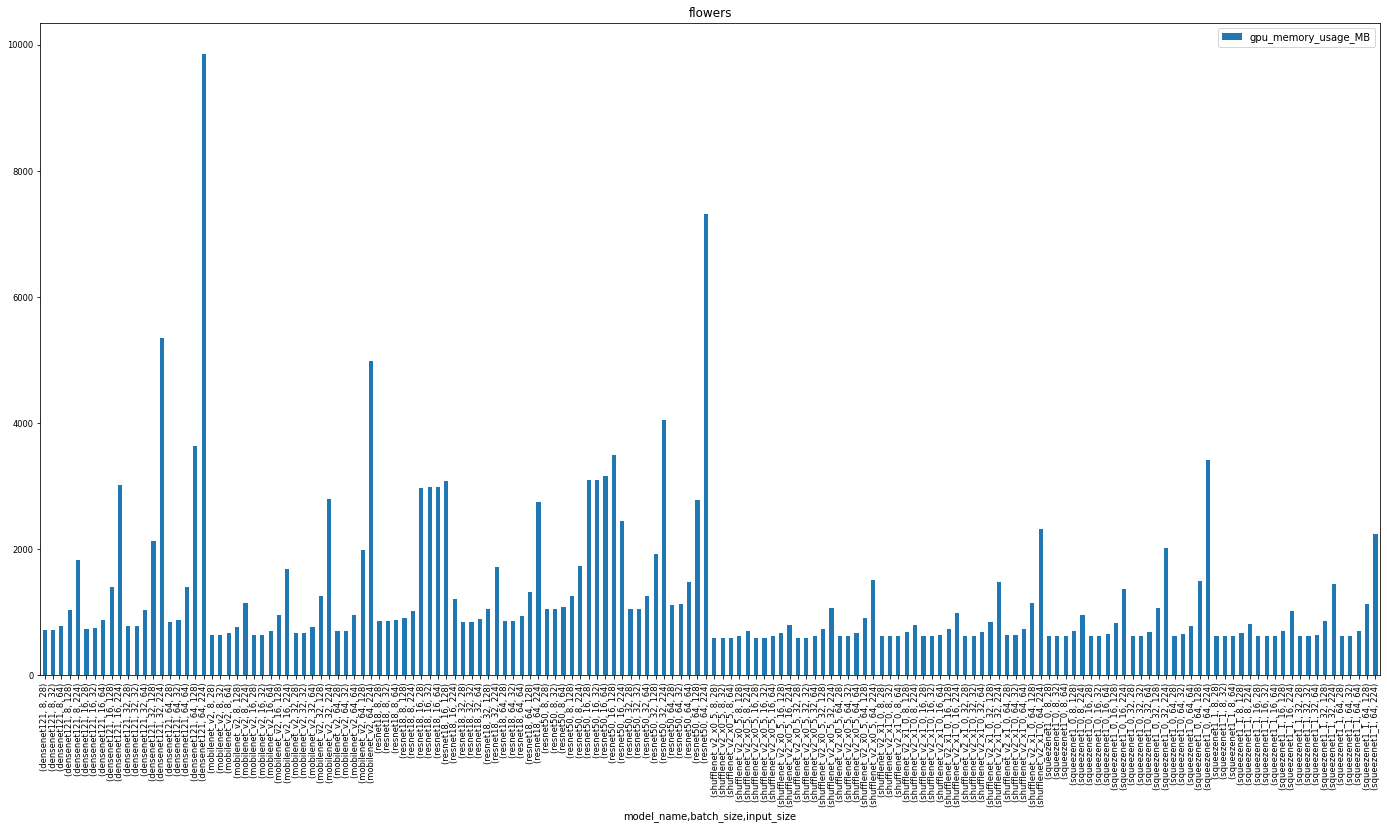

In [39]:
table_flowers.plot(kind='bar', y='gpu_memory_usage_MB', figsize=(24, 12), fontsize='small', title='flowers');

#### 整体CPU表

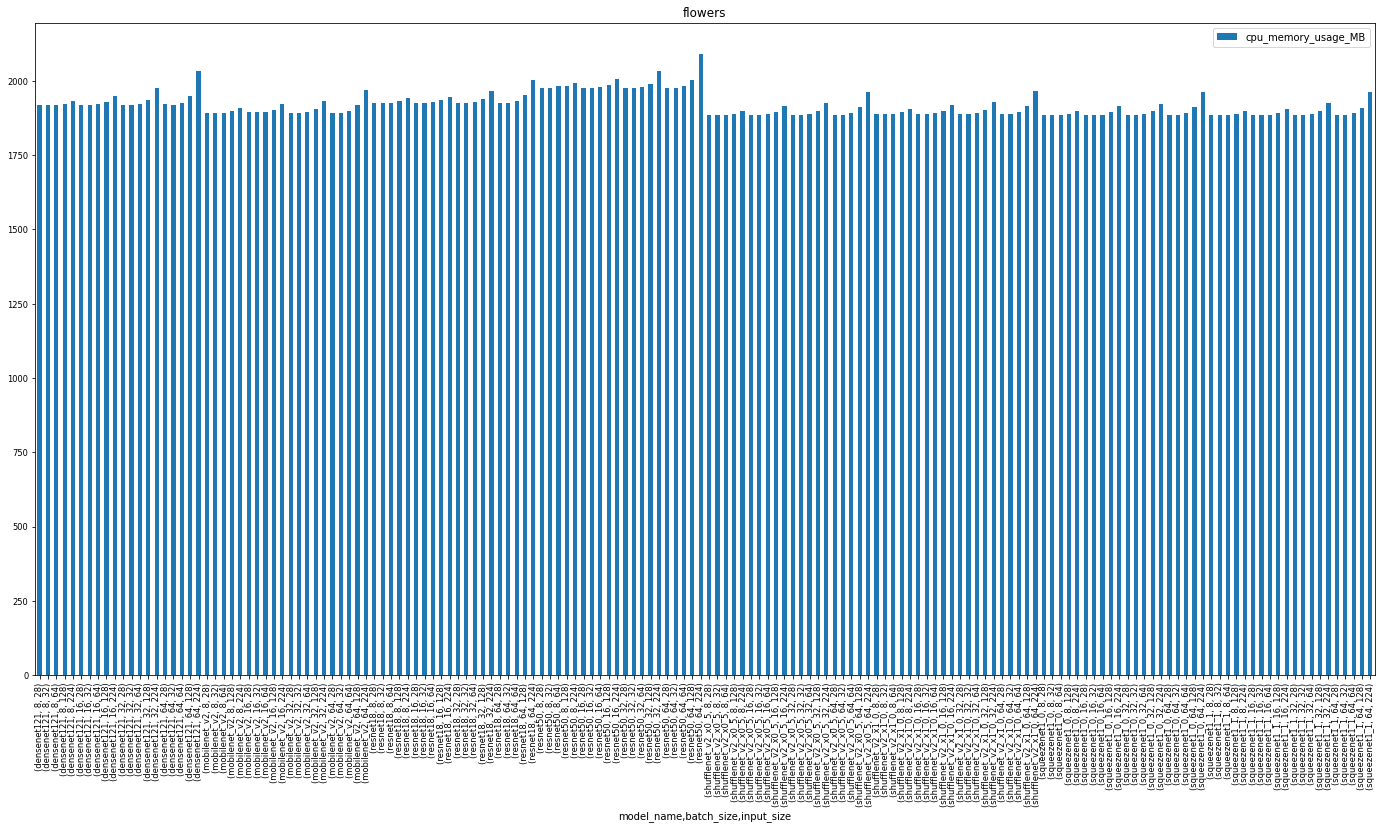

In [40]:
table_flowers.plot(kind='bar', y='cpu_memory_usage_MB', figsize=(24, 12), fontsize='small', title='flowers');

#### 整体时间消耗表

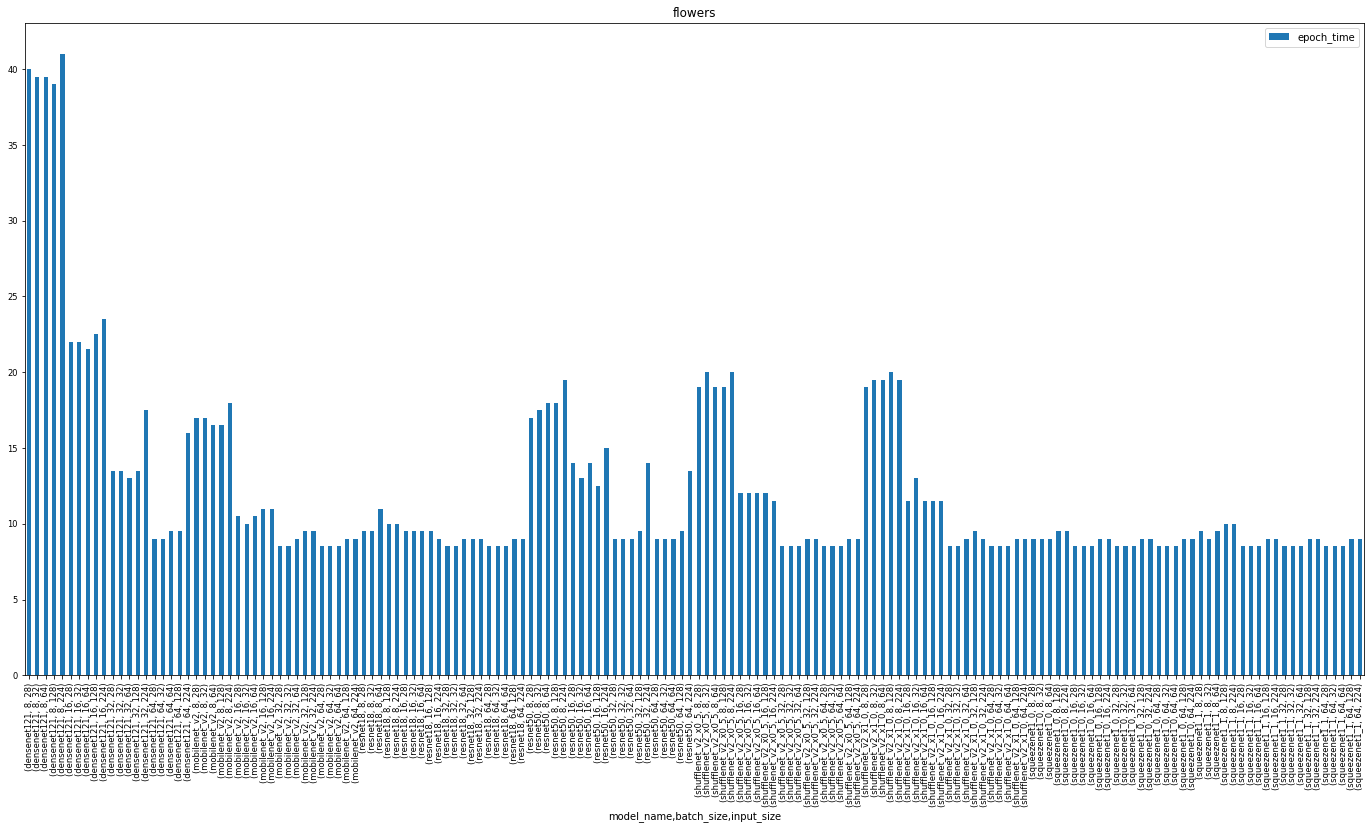

In [41]:
table_flowers.plot(kind='bar', y='epoch_time', figsize=(24, 12), fontsize='small', title='flowers');

#### 模型GPU表

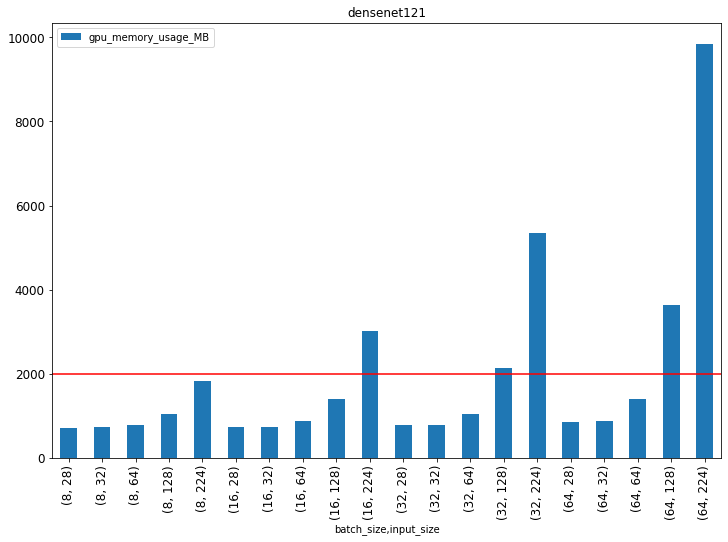

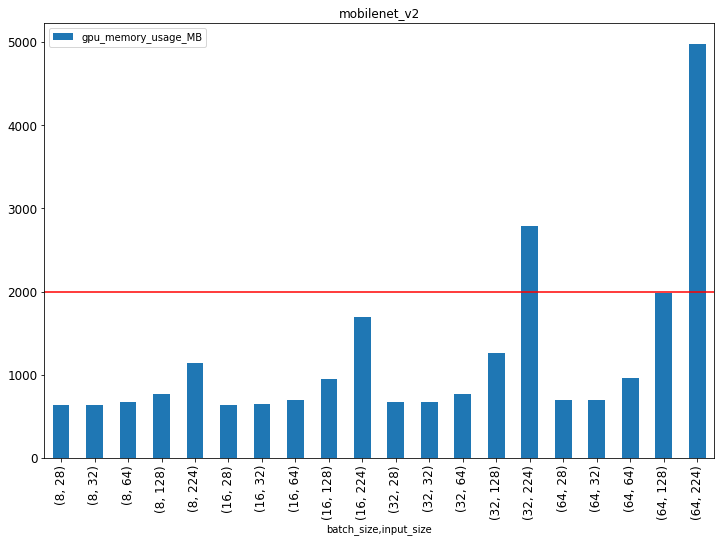

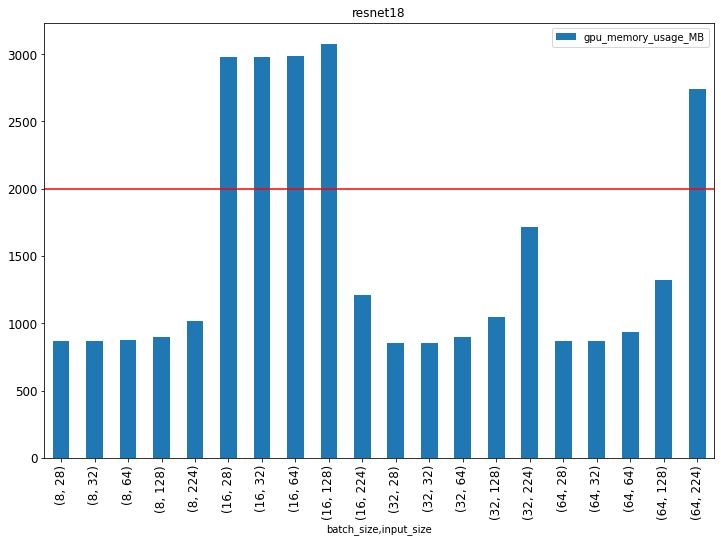

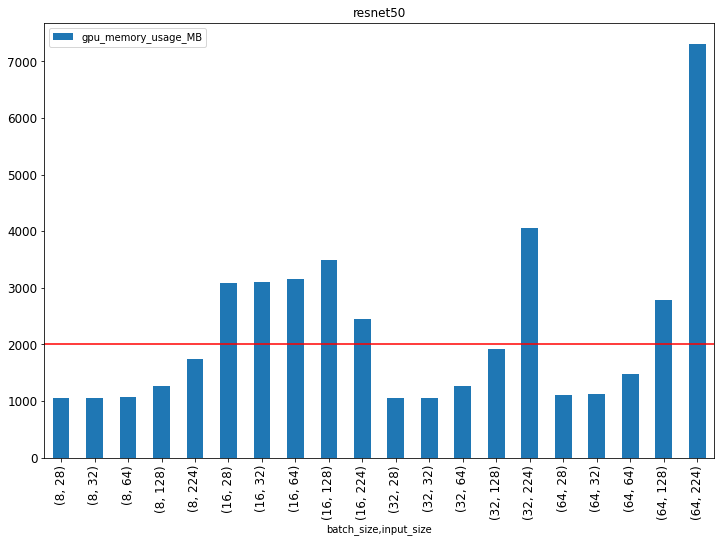

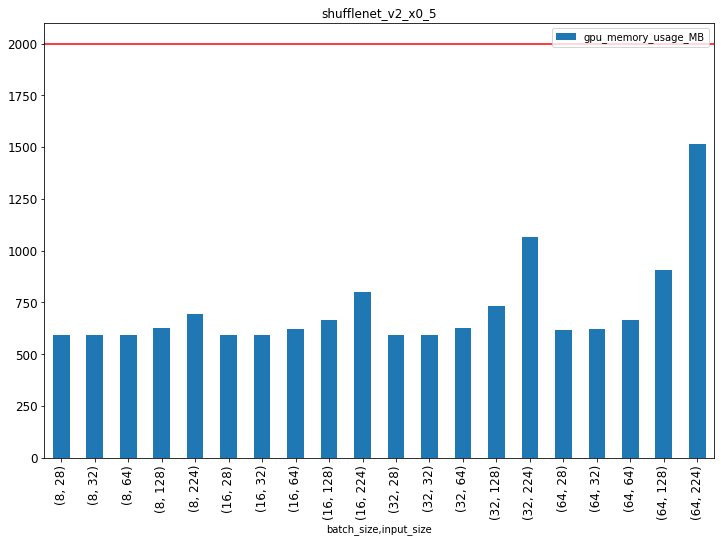

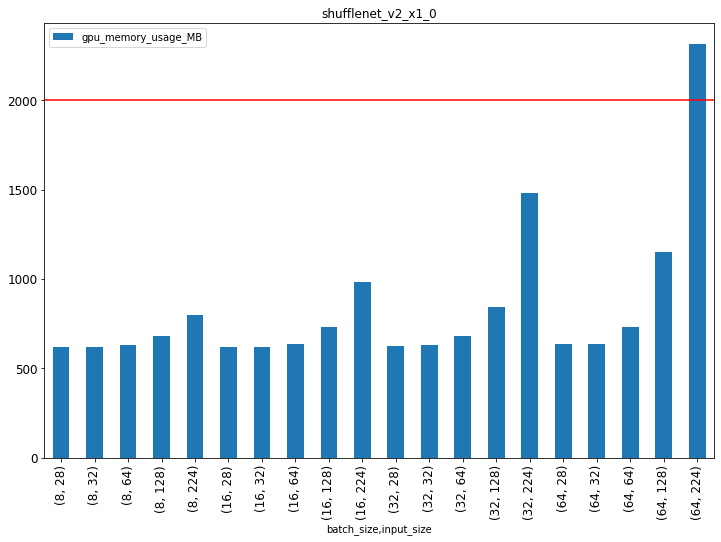

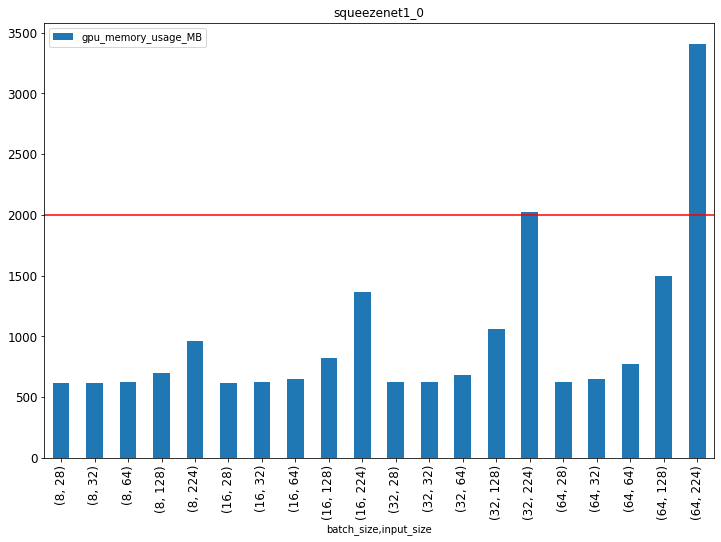

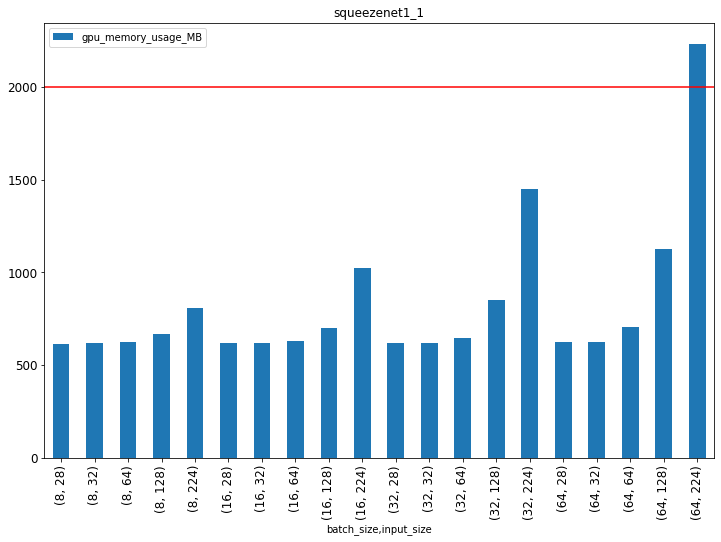

In [42]:
models_grouped = df_flowers.groupby(by='model_name')
for model_name in models_grouped.groups:
    model_df = models_grouped.get_group(model_name)
    table = pd.pivot_table(model_df, index=['batch_size', 'input_size']) 
    table.plot(kind='bar', title=f'{model_name}', y='gpu_memory_usage_MB', figsize=(12, 8), fontsize=12) 
    xmin, xmax = plt.xlim()
    plt.hlines(y=2000, xmin=xmin, xmax=xmax, colors='red')

#### 模型CPU表

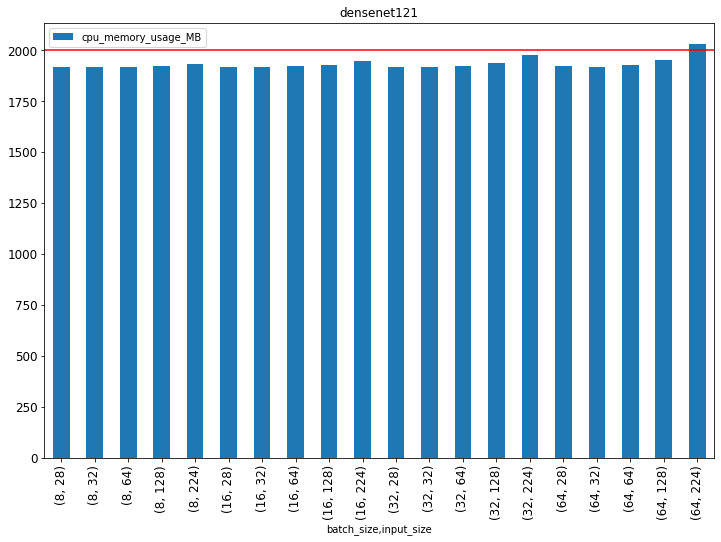

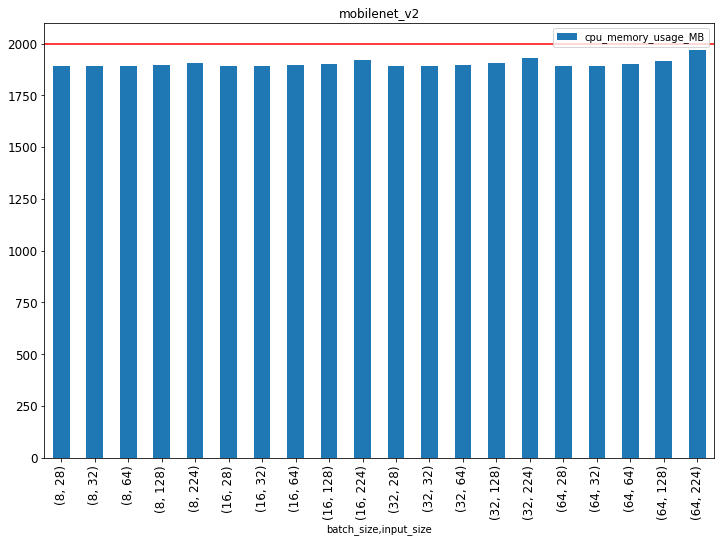

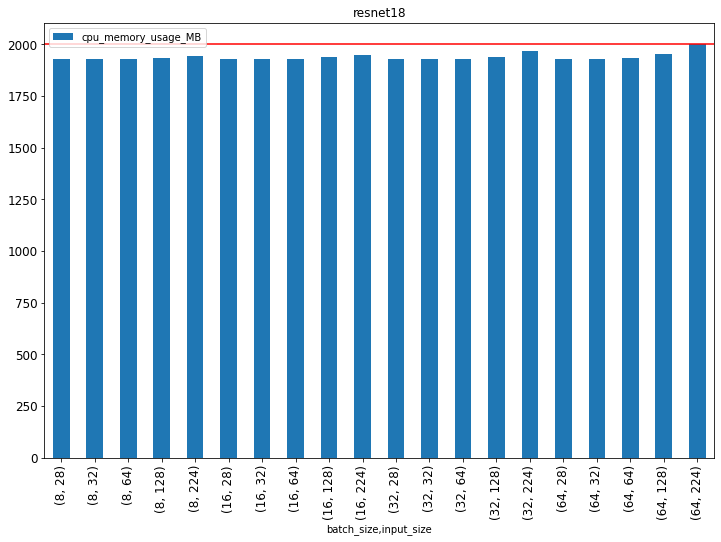

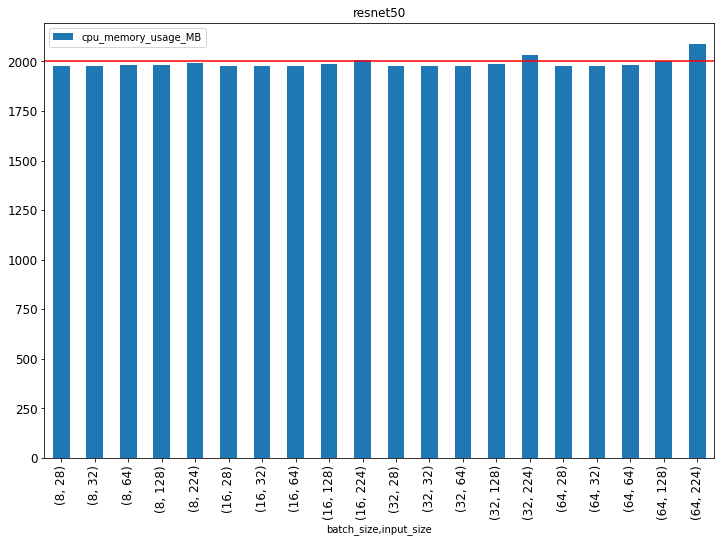

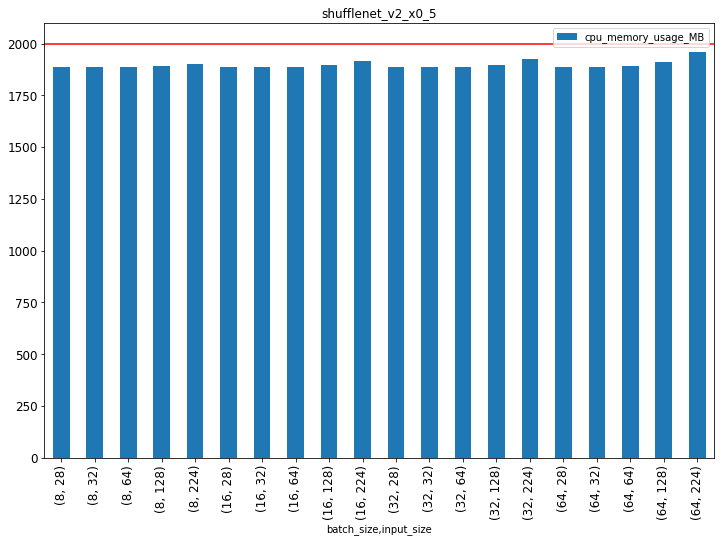

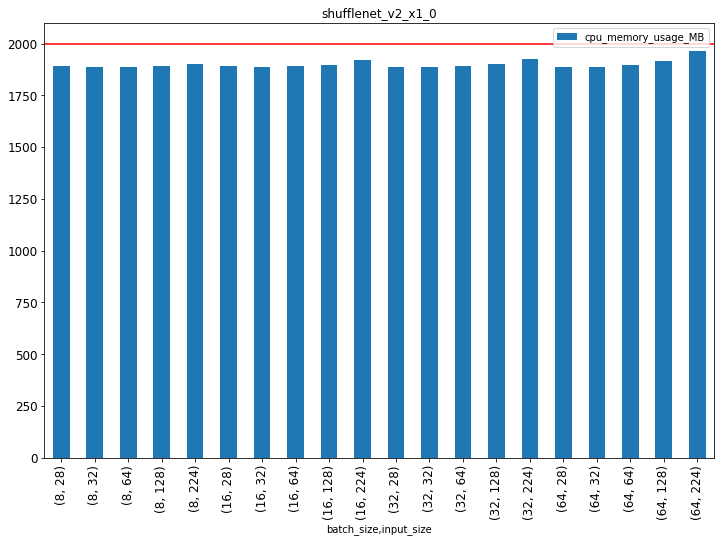

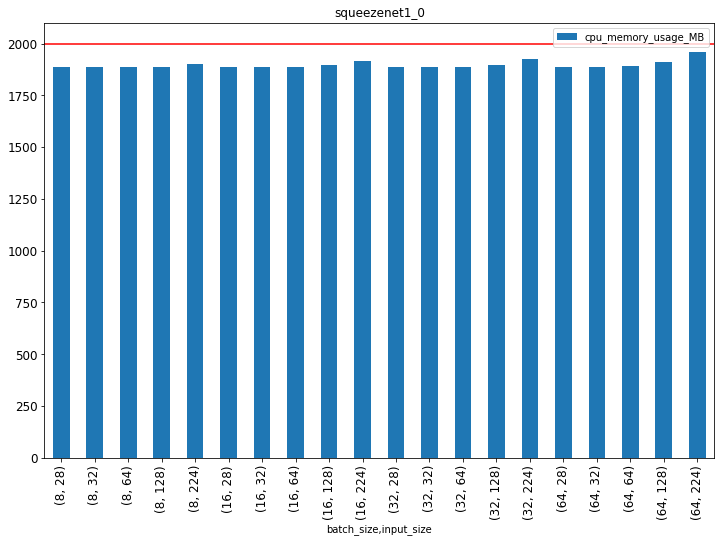

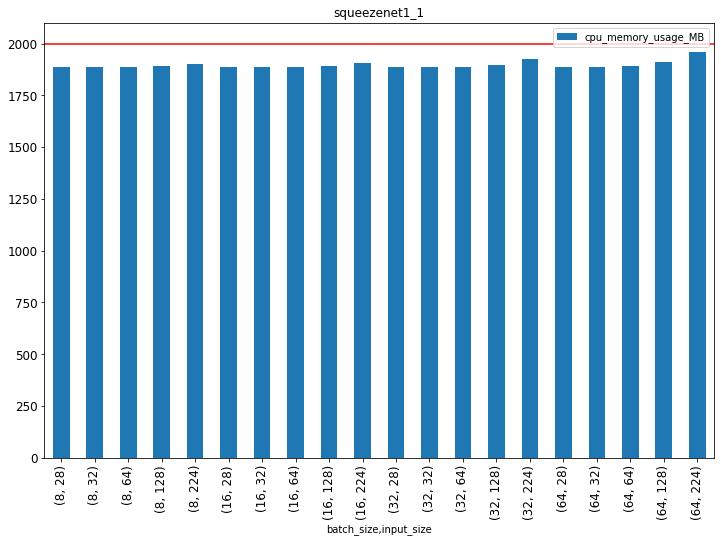

In [43]:
models_grouped = df_flowers.groupby(by='model_name')
for model_name in models_grouped.groups:
    model_df = models_grouped.get_group(model_name)
    table = pd.pivot_table(model_df, index=['batch_size', 'input_size']) 
    table.plot(kind='bar', title=f'{model_name}', y='cpu_memory_usage_MB', figsize=(12, 8), fontsize=12) 
    xmin, xmax = plt.xlim()
    plt.hlines(y=2000, xmin=xmin, xmax=xmax, colors='red')

#### 模型时间消耗表

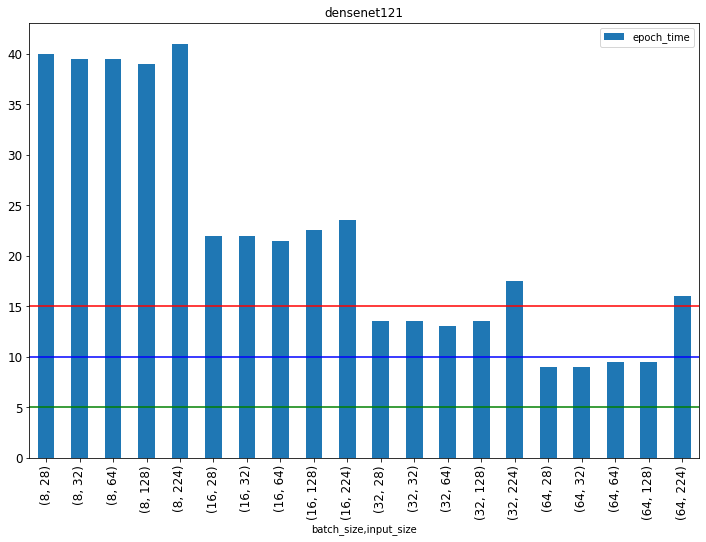

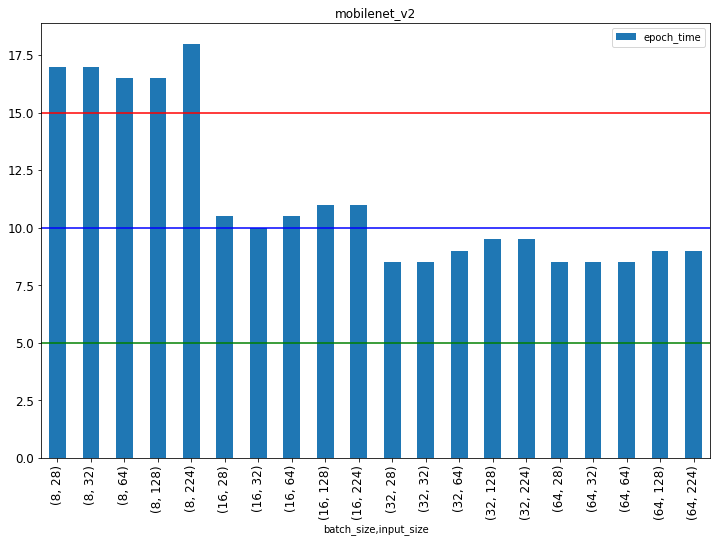

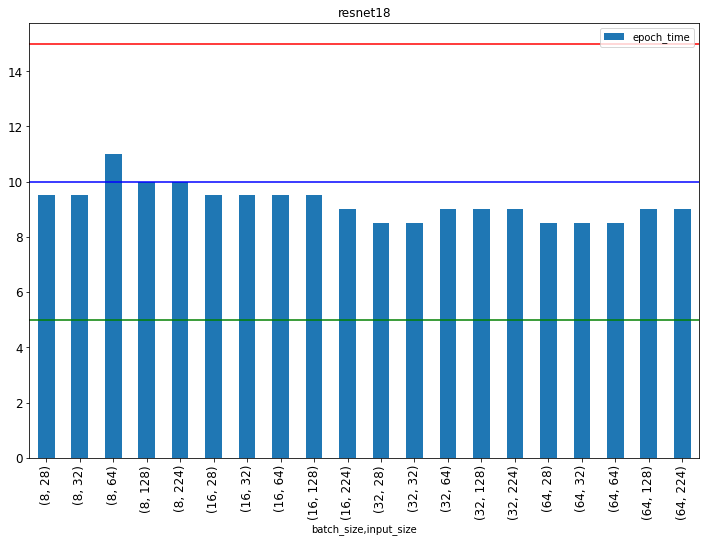

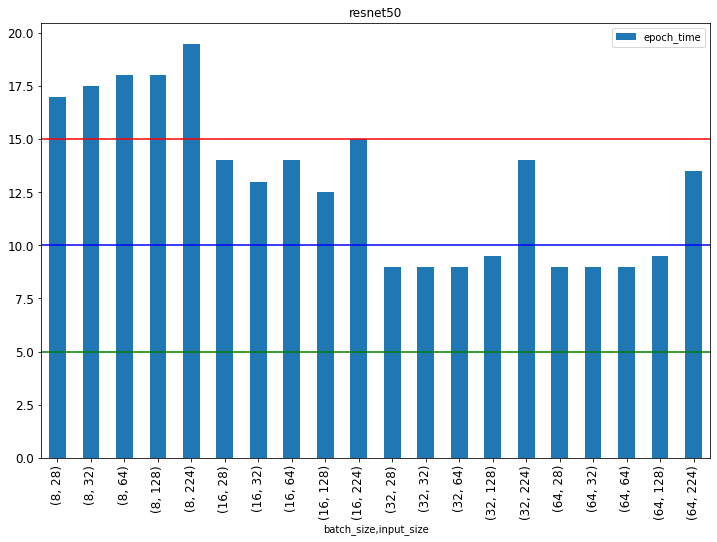

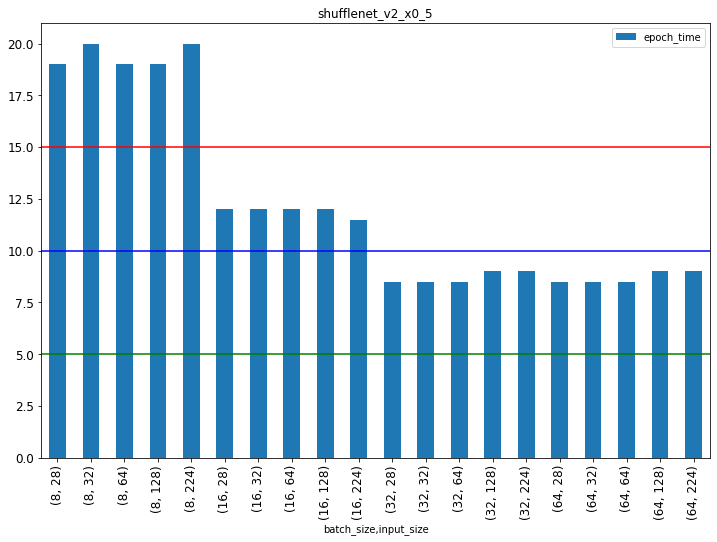

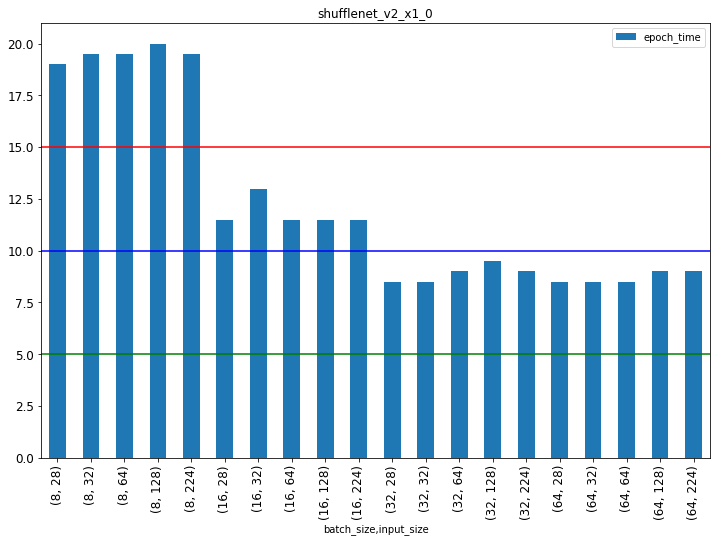

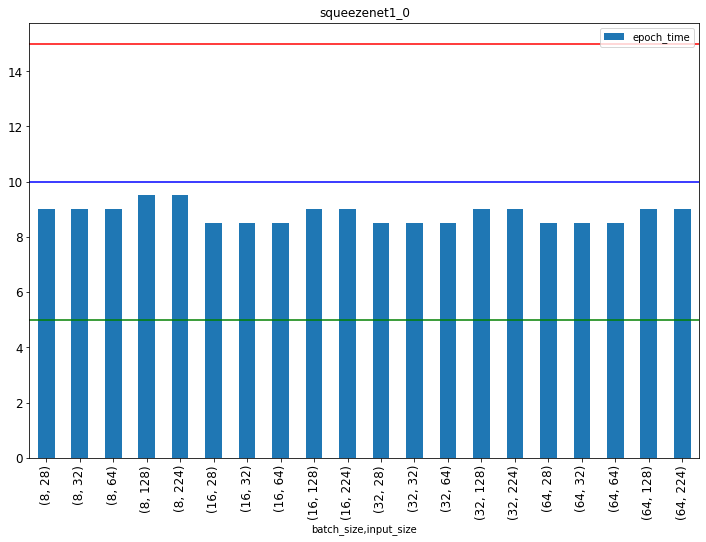

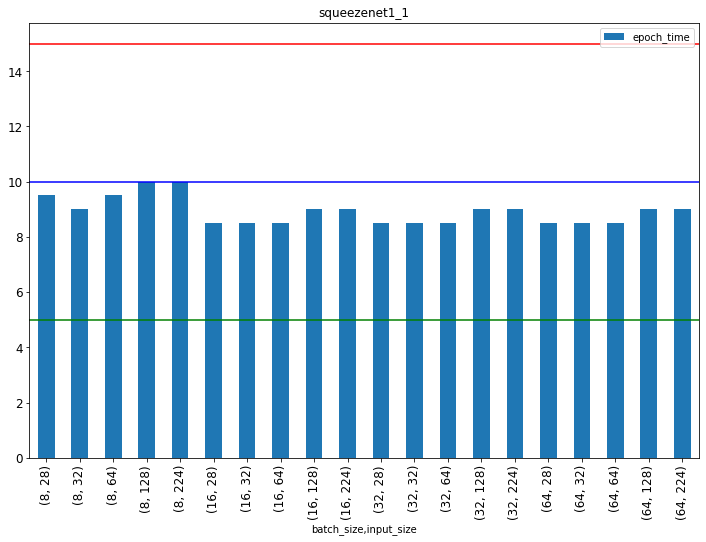

In [44]:
models_grouped = df_flowers.groupby(by='model_name')
for model_name in models_grouped.groups:
    model_df = models_grouped.get_group(model_name)
    table = pd.pivot_table(model_df, index=['batch_size', 'input_size']) 
    table.plot(kind='bar', title=f'{model_name}', y='epoch_time', figsize=(12, 8), fontsize=12) 
    xmin, xmax = plt.xlim()
    plt.hlines(y=5, xmin=xmin, xmax=xmax, colors='green')
    plt.hlines(y=10, xmin=xmin, xmax=xmax, colors='blue')
    plt.hlines(y=15, xmin=xmin, xmax=xmax, colors='red')